In [2]:
# === Q1) Avg departure delay & % late ========================================
# --- Guard: make sure `master` exists before using it ---

import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt

# Choose lateness rule (0 = any positive delay is late; try 5 for grace window)
LATE_THRESH_MIN = 0

# Work on a copy; keep labels even if missing
q1 = master.copy()
q1["carrier"] = q1["carrier"].fillna("UNK")
q1["fleet_type"] = q1["fleet_type"].fillna("UNK")

# ---- Overall ----
q1_overall = pd.DataFrame({
    "avg_dep_delay_min": [q1["dep_delay_min"].mean()],
    "%_late": [100.0 * (q1["dep_delay_min"] > LATE_THRESH_MIN).mean()],
    "n_flights": [q1["dep_delay_min"].notna().sum()]
})
("\nQ1 Overall:")
display(q1_overall.round(2))

# ---- By Carrier × Fleet Type ----
grp = (q1.groupby(["carrier","fleet_type"], as_index=False)
         .agg(avg_dep_delay_min=("dep_delay_min","mean"),
              pct_late=("dep_delay_min", lambda s: 100.0*(s > LATE_THRESH_MIN).mean()),
              n=("flight_key","count"))
      )

# Filter tiny groups to avoid noise (tune MIN_N as needed)
MIN_N = 10
grp_stable = grp.loc[grp["n"] >= MIN_N].copy()

(f"\nQ1b (Carrier × Fleet, n≥{MIN_N}) — Top 20 by % late:")
display(grp_stable.sort_values(["pct_late","avg_dep_delay_min","n"], ascending=[False,False,False])
                 .head(20).round({"avg_dep_delay_min":2,"pct_late":2}))

# ---- Chart A: Per-carrier dual-axis ----
for cr, dfc in grp_stable.groupby("carrier", sort=False):
    d = dfc.sort_values(["pct_late","avg_dep_delay_min"], ascending=False).head(12)
    if d.empty: 
        continue
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax2 = ax1.twinx()
    ax1.bar(d["fleet_type"], d["pct_late"])
    ax2.plot(d["fleet_type"], d["avg_dep_delay_min"], marker="o")
    ax1.set_title(f"{cr}: % Late vs Avg Delay by Fleet (n≥{MIN_N}, late>{LATE_THRESH_MIN}m)")
    ax1.set_ylabel("% late"); ax1.set_ylim(0,100); ax1.set_yticks(range(0,101,10))
    ax2.set_ylabel("Avg delay (min)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout(); plt.show()

# ---- Chart B: Bubble overview (one point per carrier×fleet) ----
plt.figure(figsize=(9,6))
sns.scatterplot(
    data=grp_stable, x="pct_late", y="avg_dep_delay_min",
    size="n", hue="carrier", sizes=(40, 400), alpha=0.6
)
plt.xlim(0,100); plt.xlabel("% late")
plt.ylabel("Avg delay (min)")
plt.title(f"Carrier × Fleet: % Late vs Avg Delay (bubble size = #flights, late>{LATE_THRESH_MIN}m)")
plt.tight_layout(); plt.show()

# ---- Optional: by Destination (for a route view) ----
by_dest = (q1.groupby("scheduled_arrival_station_code", as_index=False)
             .agg(avg_dep_delay_min=("dep_delay_min","mean"),
                  pct_late=("dep_delay_min", lambda s: 100.0*(s > LATE_THRESH_MIN).mean()),
                  n=("flight_key","count"))
             .sort_values(["pct_late","avg_dep_delay_min"], ascending=False))
("\nRoutes (destinations) with highest % late (Top 15):")
display(by_dest.head(15).round(2))


RuntimeError: `master` is not defined. Run the cell that builds the merged flight table (flights + loads + bags + SSR) to create `master`.

In [4]:
# Robust local Jupyter loader (recursive search + fuzzy match)
import pandas as pd, re
from pathlib import Path

DATA_DIR = Path(r"/Users/sparshmanglesh/Desktop/UA HACKATHON")  # <- keep/change

# 1) find all csvs recursively
csv_paths = list(DATA_DIR.rglob("*.csv"))
(f"Found {len(csv_paths)} CSV(s) under {DATA_DIR}.")

def norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", s.lower())

def pick(keyword_all, keyword_none=()):
    for p in csv_paths:
        n = norm(p.name)
        if all(k in n for k in keyword_all) and all(k not in n for k in keyword_none):
            return p
    return None

paths = {
    "airports":   pick(["airport"]),
    "bags":       pick(["bag"], ["pnr"]),
    "flights":    pick(["flight","level","data"], ["pnr"]),
    "pnr_remark": pick(["pnr","remark"]),
    "pnr_flight": pick(["pnr","flight"]),
}

missing = [k for k,v in paths.items() if v is None]
if missing:
    ("Couldn't auto-detect:", missing)
    ("Here are all CSV names I found:")
    for p in csv_paths: (" •", p.name)
    raise FileNotFoundError("Rename files to include the keywords shown above or move them into this folder.")

# 2) read
df_air = pd.read_csv(paths["airports"])
df_bag = pd.read_csv(paths["bags"])
df_flt = pd.read_csv(paths["flights"])
df_rem = pd.read_csv(paths["pnr_remark"])
df_pf  = pd.read_csv(paths["pnr_flight"])

("\nLoaded files:")
for k,p in paths.items():
    (f"  {k:11s} -> {p}")
("\nShapes:",
      "airports", df_air.shape, "|",
      "bags", df_bag.shape, "|",
      "flights", df_flt.shape, "|",
      "pnr_remark", df_rem.shape, "|",
      "pnr_flight", df_pf.shape)


Found 8 CSV(s) under /Users/sparshmanglesh/Desktop/UA HACKATHON.

Loaded files:
  airports    -> /Users/sparshmanglesh/Desktop/UA HACKATHON/original data /Airports Data.csv
  bags        -> /Users/sparshmanglesh/Desktop/UA HACKATHON/original data /Bag+Level+Data.csv
  flights     -> /Users/sparshmanglesh/Desktop/UA HACKATHON/my analysis/Flight Level Data2(in).csv
  pnr_remark  -> /Users/sparshmanglesh/Desktop/UA HACKATHON/original data /PNR Remark Level Data.csv
  pnr_flight  -> /Users/sparshmanglesh/Desktop/UA HACKATHON/original data /PNR+Flight+Level+Data.csv

Shapes: airports (5612, 2) | bags (687245, 8) | flights (8099, 17) | pnr_remark (51698, 4) | pnr_flight (687878, 12)


In [6]:
# === BUILD `master`: merge + feature engineering ======================================
# Requires df_air, df_bag, df_flt, df_rem, df_pf to already be loaded (your CSVs).
import pandas as pd
import numpy as np
from typing import List

pd.set_option("display.max_columns", 120)

def std_cols(df):
    df = df.copy()
    df.columns = (df.columns.str.strip()
                            .str.lower()
                            .str.replace(r"[^a-z0-9]+","_", regex=True)
                            .str.strip("_"))
    return df

def pick(df, candidates: List[str], required=False):
    for c in candidates:
        if c in df.columns: return c
    if required:
        raise KeyError(f"Missing required column; tried: {candidates}")
    return None

def upper(df, cols):
    df = df.copy()
    for c in cols:
        if c and c in df.columns:
            df[c] = df[c].astype(str).str.strip().str.upper()
    return df

# --- 1) Standardize & parse flights ---------------------------------------------------
df_flt = std_cols(df_flt)
df_bag = std_cols(df_bag)
df_pf  = std_cols(df_pf)
df_rem = std_cols(df_rem)
df_air = std_cols(df_air)

# Likely column names (with fallbacks)
col_company   = pick(df_flt, ["company_id","carrier","airline_code"], required=True)
col_fltno     = pick(df_flt, ["flight_number","flightno","flt_no","fltnum"], required=True)
col_dep_stn   = pick(df_flt, ["scheduled_departure_station_code","departure_station_code","dep_station","dep_ap","departure_airport_code"], required=True)
col_arr_stn   = pick(df_flt, ["scheduled_arrival_station_code","arrival_station_code","arr_station","arr_ap","arrival_airport_code"], required=True)
col_sched_dep = pick(df_flt, ["scheduled_departure_datetime_local","scheduled_departure_datetime_utc","scheduled_departure_time_utc","scheduled_departure_time"], required=True)
col_actl_dep  = pick(df_flt, ["actual_departure_datetime_local","actual_departure_datetime_utc","actual_departure_time_utc","actual_departure_time"], required=True)
col_sched_arr = pick(df_flt, ["scheduled_arrival_datetime_local","scheduled_arrival_datetime_utc","scheduled_arrival_time_utc","scheduled_arrival_time"], required=True)
col_actl_arr  = pick(df_flt, ["actual_arrival_datetime_local","actual_arrival_datetime_utc","actual_arrival_time_utc","actual_arrival_time"], required=True)
col_dep_date  = pick(df_flt, ["scheduled_departure_date_local","departure_date_local","dep_date_local"])
col_seats     = pick(df_flt, ["total_seats","seats","seat_capacity"])
col_fleet     = pick(df_flt, ["fleet_type","aircraft_type","equipment","aircraft"])
col_carrier   = pick(df_flt, ["carrier", "company_id", "airline_code"])
col_sched_gt  = pick(df_flt, ["scheduled_ground_time_minutes","scheduled_ground_time_min","scheduled_ground_time"])
col_min_turn  = pick(df_flt, ["minimum_turn_minutes","min_turn_minutes","minimum_turn_time_minutes","minimum_turn"])

# Parse ISO-8601 timestamps with 'Z' (UTC) safely
for c in [col_sched_dep, col_actl_dep, col_sched_arr, col_actl_arr]:
    df_flt[c] = pd.to_datetime(df_flt[c], utc=True, errors="coerce")

# Departure date for grouping/keys
if col_dep_date and col_dep_date in df_flt.columns:
    df_flt["dep_date"] = pd.to_datetime(df_flt[col_dep_date], errors="coerce").dt.date
else:
    df_flt["dep_date"] = df_flt[col_sched_dep].dt.date

# Clean codes
df_flt = upper(df_flt, [col_company, col_dep_stn, col_arr_stn, col_carrier, col_fleet])

# Delays in minutes
df_flt["dep_delay_min"] = (df_flt[col_actl_dep] - df_flt[col_sched_dep]).dt.total_seconds() / 60.0
df_flt["arr_delay_min"] = (df_flt[col_actl_arr] - df_flt[col_sched_arr]).dt.total_seconds() / 60.0

# Turn buffer if available
if col_sched_gt and col_min_turn:
    df_flt["turn_buffer_min"] = (
        df_flt[col_sched_gt].astype(float) - df_flt[col_min_turn].astype(float)
    )
else:
    df_flt["turn_buffer_min"] = np.nan

# Build flight_key
df_flt[col_fltno] = df_flt[col_fltno].astype(str).str.strip()
df_flt["flight_key"] = (
    df_flt[col_company].astype(str) + "|" +
    df_flt[col_fltno].astype(str) + "|" +
    df_flt["dep_date"].astype(str) + "|" +
    df_flt[col_dep_stn].astype(str) + "|" +
    df_flt[col_arr_stn].astype(str)
)

# Keep a tidy flight table
keep_cols = {
    "flight_key","dep_date", col_company, col_fltno, col_dep_stn, col_arr_stn,
    col_sched_dep, col_actl_dep, col_sched_arr, col_actl_arr,
    "dep_delay_min","arr_delay_min",
    col_seats, col_fleet, col_carrier, col_sched_gt, col_min_turn, "turn_buffer_min"
}
flt = df_flt[list({c for c in keep_cols if c and c in df_flt.columns})].drop_duplicates("flight_key")

# --- 2) Bags -> flight level (checked vs transfer; robust) ---------------------------
# Detect transfer by text; compute totals; derive checked = total - transfer
if "bag_type" in df_bag.columns:
    df_bag["is_transfer"] = df_bag["bag_type"].astype(str).str.contains("TRANSFER", case=False, na=False)
else:
    df_bag["is_transfer"] = False  # fallback

# Need a flight_key on bags: build it using the same components if present
for col in [col_company, col_fltno, col_dep_stn, col_arr_stn]:
    if col not in df_bag.columns and col in df_flt.columns:
        # try to copy from similarly named columns in bag file (best-effort)
        match = [c for c in df_bag.columns if c.endswith(col)]
        if match:
            df_bag[col] = df_bag[match[0]]

if "scheduled_departure_date_local" in df_bag.columns:
    df_bag["dep_date"] = pd.to_datetime(df_bag["scheduled_departure_date_local"], errors="coerce").dt.date
elif col_sched_dep in df_bag.columns:
    df_bag["dep_date"] = pd.to_datetime(df_bag[col_sched_dep], errors="coerce").dt.date
else:
    # as last resort, try to derive from bag_tag_issue_date if present
    if "bag_tag_issue_date" in df_bag.columns:
        df_bag["dep_date"] = pd.to_datetime(df_bag["bag_tag_issue_date"], errors="coerce").dt.date

# Build flight_key for bags when possible
if all(c in df_bag.columns for c in [col_company, col_fltno, "dep_date", col_dep_stn, col_arr_stn]):
    df_bag["flight_key"] = (
        df_bag[col_company].astype(str).str.upper() + "|" +
        df_bag[col_fltno].astype(str).str.strip() + "|" +
        df_bag["dep_date"].astype(str) + "|" +
        df_bag[col_dep_stn].astype(str).str.upper() + "|" +
        df_bag[col_arr_stn].astype(str).str.upper()
    )

bag_g = (df_bag.dropna(subset=["flight_key"])  # only rows where we could form the key
              .groupby("flight_key", as_index=False)
              .agg(transfer_bags=("is_transfer","sum"),
                   total_bags=("is_transfer","size")))
bag_g["checked_bags"] = (bag_g["total_bags"] - bag_g["transfer_bags"]).clip(lower=0)

# --- 3) PNR-flight loads & SSR counts ----------------------------------------------
# Loads: total passengers per flight_key
df_pf["flight_key"] = None  # we will build one too
# try to assemble keys in PNR flight
for col in [col_company, col_fltno, col_dep_stn, col_arr_stn]:
    if col not in df_pf.columns and col in df_flt.columns:
        m = [c for c in df_pf.columns if c.endswith(col)]
        if m:
            df_pf[col] = df_pf[m[0]]

if "scheduled_departure_date_local" in df_pf.columns:
    df_pf["dep_date"] = pd.to_datetime(df_pf["scheduled_departure_date_local"], errors="coerce").dt.date
elif col_sched_dep in df_pf.columns:
    df_pf["dep_date"] = pd.to_datetime(df_pf[col_sched_dep], errors="coerce").dt.date

if all(c in df_pf.columns for c in [col_company, col_fltno, "dep_date", col_dep_stn, col_arr_stn]):
    df_pf["flight_key"] = (
        df_pf[col_company].astype(str).str.upper() + "|" +
        df_pf[col_fltno].astype(str).str.strip() + "|" +
        df_pf["dep_date"].astype(str) + "|" +
        df_pf[col_dep_stn].astype(str).str.upper() + "|" +
        df_pf[col_arr_stn].astype(str).str.upper()
    )

# passenger column (fallbacks)
col_pax = pick(df_pf, ["total_pax","total_passengers","pax_count","passenger_count"])
if col_pax:
    loads = df_pf.dropna(subset=["flight_key"]).groupby("flight_key", as_index=False)[col_pax].sum()
    loads = loads.rename(columns={col_pax:"total_pax"})
else:
    # fallback: treat each PNR row as 1 pax (crude)
    loads = df_pf.dropna(subset=["flight_key"]).groupby("flight_key", as_index=False).size()
    loads = loads.rename(columns={"size":"total_pax"})

# SSR: join remarks to PNR-flight to get flight_key, then count
col_rec = pick(df_pf, ["record_locator","pnr_locator","pnr_id"], required=False) or pick(df_rem, ["record_locator","pnr_locator","pnr_id"], required=True)
if col_rec not in df_pf.columns and col_rec in df_rem.columns:
    # if pf lacks record locator, try to merge by shared columns (company, flight, date, stns)
    join_cols = [c for c in [col_company, col_fltno, "dep_date", col_dep_stn, col_arr_stn] if c in df_pf.columns and c in df_rem.columns]
    df_rem_fk = df_rem.merge(df_pf[join_cols + ["flight_key"]].drop_duplicates(), on=join_cols, how="left")
else:
    df_rem_fk = df_rem.merge(df_pf[[col_rec, "flight_key"]].drop_duplicates(), on=col_rec, how="left")

ssr = (df_rem_fk.dropna(subset=["flight_key"])
               .groupby("flight_key", as_index=False)
               .size().rename(columns={"size":"ssr_count"}))

# --- 4) Merge into master & engineer fields -----------------------------------------
master = (flt
          .merge(loads,  on="flight_key", how="left")
          .merge(ssr,    on="flight_key", how="left")
          .merge(bag_g,  on="flight_key", how="left"))

# Fill sensible zeros
for c in ["total_pax","ssr_count","checked_bags","transfer_bags","total_bags"]:
    if c in master.columns:
        master[c] = master[c].fillna(0)

# Load factor, BCI, SSR per 100
if col_seats and col_seats in master.columns:
    master["load_factor"] = np.where(master[col_seats].astype(float) > 0,
                                     master["total_pax"].astype(float) / master[col_seats].astype(float),
                                     np.nan)
else:
    master["load_factor"] = np.nan

master["bci"] = np.where(master["checked_bags"].astype(float) > 0,
                         master["transfer_bags"].astype(float) / master["checked_bags"].astype(float),
                         np.nan)
master["ssr_per_100"] = np.where(master["total_pax"].astype(float) > 0,
                                 100.0 * master["ssr_count"].astype(float) / master["total_pax"].astype(float),
                                 0.0)

# Convenience aliases expected by Q1
if "carrier" not in master.columns and col_carrier:
    master["carrier"] = master[col_carrier]
if "fleet_type" not in master.columns and col_fleet:
    master["fleet_type"] = master[col_fleet]
if "scheduled_arrival_station_code" not in master.columns and col_arr_stn:
    master["scheduled_arrival_station_code"] = master[col_arr_stn]

# Final hygiene
master.replace([np.inf,-np.inf], np.nan, inplace=True)

# --- 5) Quick sanity s -----------------------------------------------------------
need = {"dep_delay_min","carrier","fleet_type","flight_key","scheduled_arrival_station_code"}
missing = need - set(master.columns)
(f"`master` ready: {master.shape[0]} rows, {master.shape[1]} cols. Missing for Q1: {missing if missing else 'None'}")
display(master[list((need & set(master.columns)))].head())


`master` ready: 7001 rows, 26 cols. Missing for Q1: None


,dep_delay_min,flight_key,scheduled_arrival_station_code,carrier,fleet_type
0,7.0,OO|4792|2025-04-08|ORD|ROA,ROA,EXPRESS,ERJ-175
1,22.0,UA|920|2025-03-08|ORD|LHR,LHR,MAINLINE,B767-300
2,111.0,UA|1776|2025-10-08|ORD|PHL,PHL,MAINLINE,B737-800
3,105.0,OO|5790|2025-06-08|ORD|CRW,CRW,EXPRESS,CRJ-200
4,-4.0,UA|1398|2025-05-08|ORD|ATL,ATL,MAINLINE,B737-800


Overall:


,avg_dep_delay_min,%_late,n_flights
0,21.02,49.51,7001



Q1b (Carrier × Fleet, n≥0) 


,carrier,fleet_type,avg_dep_delay_min,pct_late,n
14,MAINLINE,B767-300,51.98,86.54,52
19,MAINLINE,B787-8,42.02,81.97,61
18,MAINLINE,B787-10,35.01,74.17,120
12,MAINLINE,B757-200,49.36,72.53,91
13,MAINLINE,B757-300,35.30,70.77,130
9,MAINLINE,B737-900,24.56,56.92,701
4,MAINLINE,A319-100,19.28,54.94,435
7,MAINLINE,B737-700,18.82,53.80,342
8,MAINLINE,B737-800,21.15,53.18,581
5,MAINLINE,A320-200,20.58,50.70,430


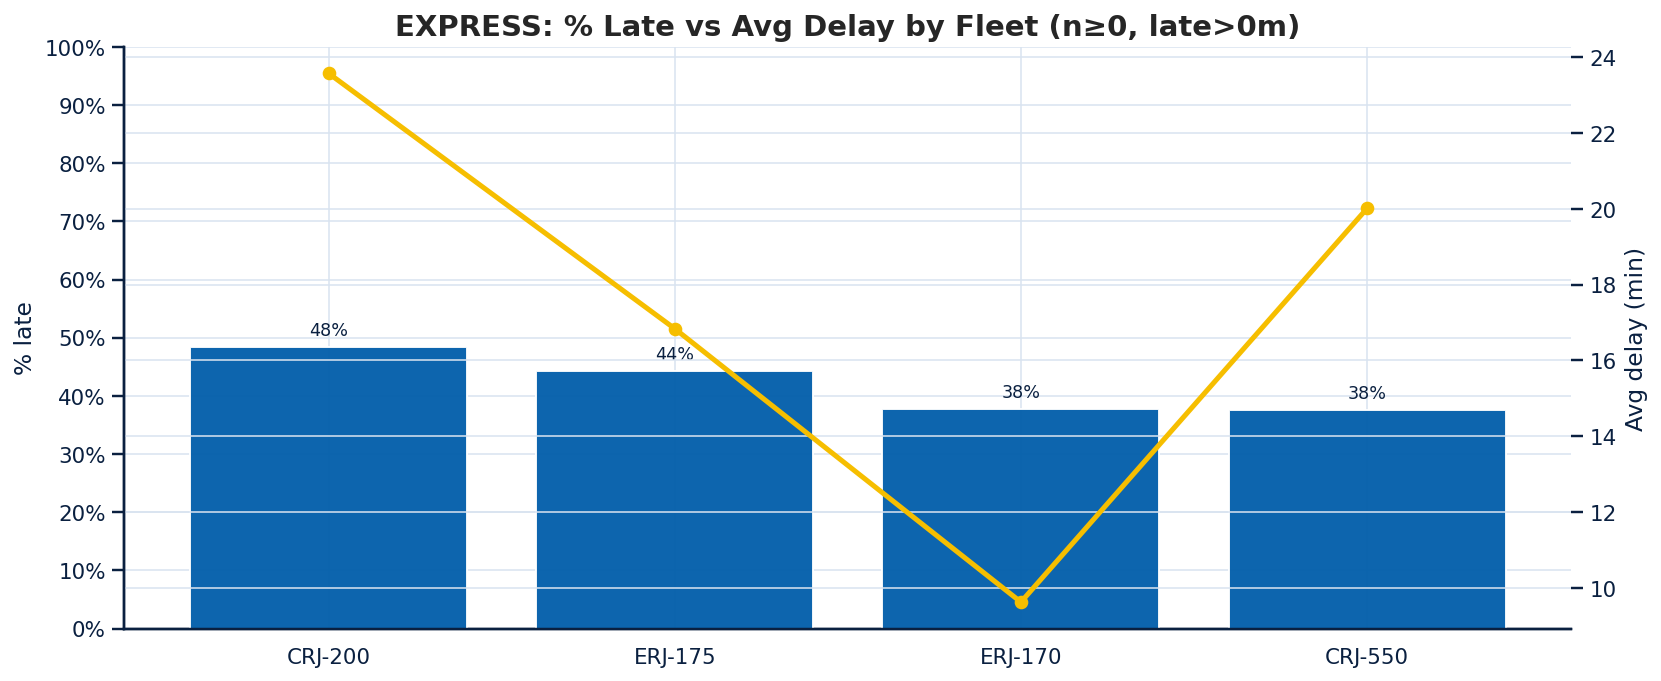

Saved: Q1_EXPRESS_fleet_dualaxis.png


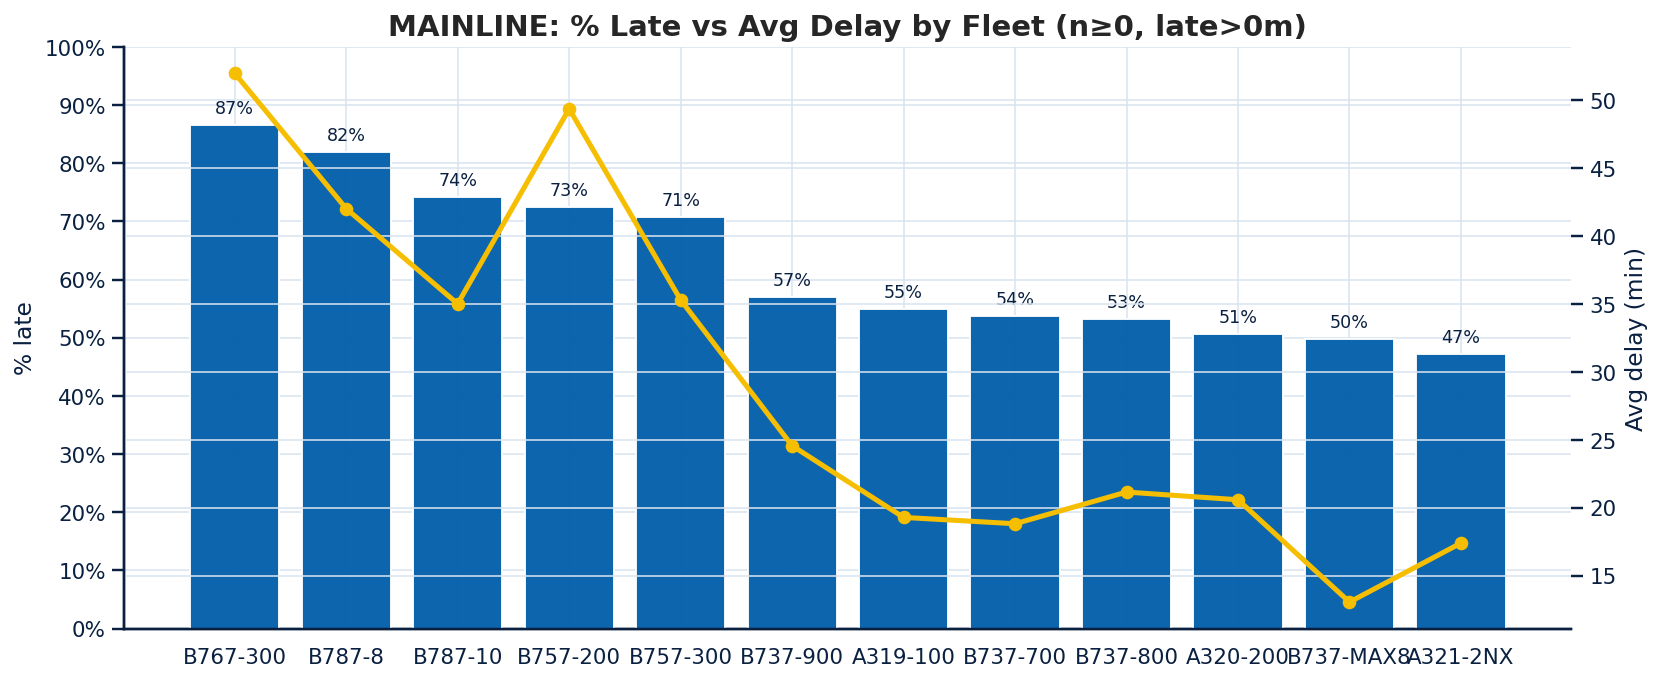

Saved: Q1_MAINLINE_fleet_dualaxis.png


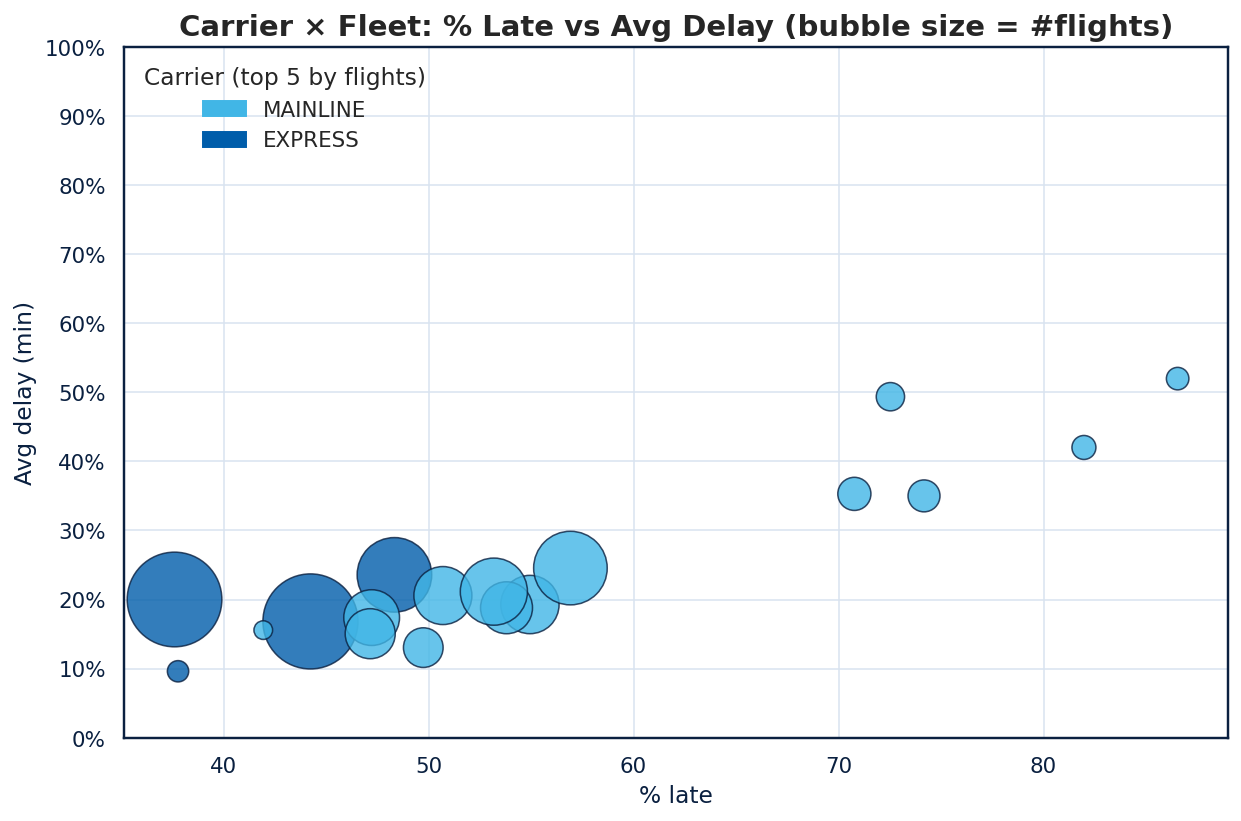

Saved: Q1_bubble_overview.png

Routes (destinations) with highest % late (Top 15):


,scheduled_arrival_station_code,avg_dep_delay_min,pct_late,n
73,GRU,72.77,100.00,13
126,ONT,64.85,100.00,13
60,FAT,60.17,100.00,12
22,BRU,42.54,100.00,13
77,GUA,5.00,100.00,4
119,MUC,30.85,92.31,13
97,LHR,64.10,87.18,39
169,SUN,54.71,85.71,7
14,BCN,51.31,84.62,13
54,EDI,46.69,84.62,13


In [23]:
# === Q1) Avg departure delay & % late (overall + by CARRIER × FLEET, UA style) ======
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator
from IPython.display import display

# ---------- Guard: `master` must exist and have needed columns ----------
if 'master' not in globals():
    if 'sc' in globals():
        master = sc.copy()
    else:
        raise RuntimeError("`master` is not defined. Run the merge/feature-engineering cell that builds it.")

need = {'dep_delay_min','carrier','fleet_type','flight_key','scheduled_arrival_station_code'}
missing = need - set(master.columns)
if missing:
    raise RuntimeError(f"`master` is missing columns: {missing}. Re-run the merge/feature-engineering cell.")

# ---------- Parameters ----------
LATE_THRESH_MIN = 0   # set to 5 for a grace window ("> 5 min late")
MIN_N = 0            # minimum flights per group to plot

# ---------- UA color theme ----------
UA_BLUE   = "#005DAA"   # United blue
UA_NAVY   = "#0A2040"   # deep navy
UA_SKY    = "#41B6E6"   # sky blue
UA_GOLD   = "#F6BE00"   # accent
UA_GRAY   = "#6E7881"   # neutral
UA_MID    = "#0072CE"
UA_LIGHT  = "#9BD3F7"

plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "savefig.transparent": True,
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "axes.edgecolor": UA_NAVY,
    "axes.labelcolor": UA_NAVY,
    "axes.titleweight": "bold",
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "xtick.color": UA_NAVY,
    "ytick.color": UA_NAVY,
    "grid.color": "#D9E3F0",
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    "axes.grid": True,
    "legend.frameon": False,
    "font.size": 11,
    "font.family": "DejaVu Sans",
})

def _format_pct_axis(ax):
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_locator(MaxNLocator(11))
    ax.yaxis.set_major_formatter(PercentFormatter(100))

def _safe_name(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9]+", "_", str(s)).strip("_")

# ---------- Prep ----------
q1 = master.copy()
q1["carrier"] = q1["carrier"].fillna("UNK")
q1["fleet_type"] = q1["fleet_type"].fillna("UNK")

# ---------- Overall ----------
q1_overall = pd.DataFrame({
    "avg_dep_delay_min": [q1["dep_delay_min"].mean()],
    "%_late": [100.0 * (q1["dep_delay_min"] > LATE_THRESH_MIN).mean()],
    "n_flights": [q1["dep_delay_min"].notna().sum()]
})
print("Overall:")
display(q1_overall.round(2))

# ---------- By Carrier × Fleet ----------
grp = (q1.groupby(["carrier","fleet_type"], as_index=False)
         .agg(avg_dep_delay_min=("dep_delay_min","mean"),
              pct_late=("dep_delay_min", lambda s: 100.0*(s > LATE_THRESH_MIN).mean()),
              n=("flight_key","count")))

print(f"\nQ1b (Carrier × Fleet, n≥{MIN_N}) ")
display(grp_stable.sort_values(["pct_late","avg_dep_delay_min","n"],
                               ascending=[False,False,False])
                 
                 .round({"avg_dep_delay_min":2, "pct_late":2}))

# ---------- UA Chart A: Per-carrier dual-axis (bars=% late, line=avg delay) ----------
if grp_stable.empty:
    print("\nNo carrier×fleet groups with n ≥ MIN_N to plot.")
else:
    for cr, dfc in grp_stable.groupby("carrier", sort=False):
        d = dfc.sort_values(["pct_late","avg_dep_delay_min"], ascending=False).head(12)
        if d.empty:
            continue
        fig, ax1 = plt.subplots(figsize=(12,5))
        ax2 = ax1.twinx()

        bars = ax1.bar(d["fleet_type"], d["pct_late"], color=UA_BLUE, alpha=0.95, zorder=3)
        ax2.plot(d["fleet_type"], d["avg_dep_delay_min"], marker="o", linewidth=2.6,
                 color=UA_GOLD, zorder=4)

        _format_pct_axis(ax1)
        ax1.set_ylabel("% late", color=UA_NAVY)
        ax2.set_ylabel("Avg delay (min)", color=UA_NAVY)
        ax1.set_title(f"{cr}: % Late vs Avg Delay by Fleet (n≥{MIN_N}, late>{LATE_THRESH_MIN}m)")

        # Labels on bars
        for r in bars:
            h = r.get_height()
            ax1.annotate(f"{h:.0f}%", (r.get_x()+r.get_width()/2, h),
                         xytext=(0,4), textcoords="offset points",
                         ha="center", va="bottom", fontsize=9, color=UA_NAVY)

        plt.xticks(rotation=28, ha="right")
        for spine in ["top","right"]:
            ax1.spines[spine].set_visible(False)
            ax2.spines[spine].set_visible(False)
        plt.tight_layout()
        out = f"Q1_{_safe_name(cr)}_fleet_dualaxis.png"
        plt.savefig(out, bbox_inches="tight")
        plt.show()
        print("Saved:", out)

# ---------- UA Chart B: Bubble overview (one point per carrier×fleet) ----------
if not grp_stable.empty:
    fig, ax = plt.subplots(figsize=(9,6))

    # color per carrier
    carriers = list(grp_stable["carrier"].unique())
    palette  = [UA_BLUE, UA_SKY, UA_MID, "#1D428A", "#0085CA", UA_LIGHT]
    color_map = {c: palette[i % len(palette)] for i, c in enumerate(carriers)}

    x = grp_stable["pct_late"].values
    y = grp_stable["avg_dep_delay_min"].values
    s = 30 + 2.0*grp_stable["n"].values  # bubble size ~ #flights
    colors = [color_map[c] for c in grp_stable["carrier"]]

    sc = ax.scatter(x, y, s=s, c=colors, edgecolors=UA_NAVY, linewidths=0.8, alpha=0.8)

    _format_pct_axis(ax)
    ax.set_xlabel("% late")
    ax.set_ylabel("Avg delay (min)")
    ax.set_title("Carrier × Fleet: % Late vs Avg Delay (bubble size = #flights)")

    # Legend: top 5 carriers by flights
    top_car = grp_stable.groupby("carrier")["n"].sum().sort_values(ascending=False).head(5)
    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(color=color_map[c], label=c) for c in top_car.index]
    if handles:
        ax.legend(handles=handles, title="Carrier (top 5 by flights)", loc="upper left")

    plt.tight_layout()
    out = "Q1_bubble_overview.png"
    plt.savefig(out, bbox_inches="tight")
    plt.show()
    print("Saved:", out)

# ---------- Optional: route view by destination (top 15) ----------
by_dest = (q1.groupby("scheduled_arrival_station_code", as_index=False)
             .agg(avg_dep_delay_min=("dep_delay_min","mean"),
                  pct_late=("dep_delay_min", lambda s: 100.0*(s > LATE_THRESH_MIN).mean()),
                  n=("flight_key","count"))
             .sort_values(["pct_late","avg_dep_delay_min"], ascending=False))

print("\nRoutes (destinations) with highest % late (Top 15):")
display(by_dest.head(15).round(2))


In [26]:
# === Q2) Turn-time risk: flights below/near minimum turn (UA-styled, segmented) ======
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display

# ---------- Guard ----------
if 'master' not in globals():
    raise RuntimeError("`master` is not defined. Run the merge/feature-engineering cell first.")

need_any = {"turn_buffer_min"}  # ok if present
need_raw = {"scheduled_ground_time_minutes","minimum_turn_minutes"}  # else we recompute
need_ids = {"scheduled_departure_station_code","fleet_type","carrier","flight_key"}
missing_ids = need_ids - set(master.columns)
if missing_ids:
    raise RuntimeError(f"`master` is missing columns: {missing_ids}")

# ---------- Parameters ----------
CLOSE_THRESH = 5   # "within +5 minutes of minimum turn"
MIN_N = 0          # min flights for station×fleet bar chart
# Robust segmentation (works even if 'segment' not already in master)
MAINLINE_CODES   = {"UA","UAL","UNITED","UNITED AIRLINES"}
EXPRESS_CARRIERS = {"OO","YX","EV","AX","RP","ZW","C5","G7"}  # typical UA regionals
import re as _re
EXPRESS_FLEET_RE = _re.compile(r"(CRJ|ERJ|E-?17[05]|E-?14[53]|EMB-?14[53]|CRJ-?(200|700|900)|DHC|Q400|DH8)", flags=_re.I)

def infer_segment(row):
    c = str(row.get("carrier","")).strip().upper()
    f = str(row.get("fleet_type","")).strip().upper()
    if c.startswith("UA") or c in MAINLINE_CODES: return "Mainline"
    if c in EXPRESS_CARRIERS: return "Express"
    if EXPRESS_FLEET_RE.search(f): return "Express"
    return "Mainline"

# ---------- UA look ----------
UA_BLUE="#005DAA"; UA_NAVY="#0A2040"; UA_SKY="#41B6E6"; UA_GOLD="#F6BE00"; UA_MID="#0072CE"; UA_GRAY="#6E7881"
plt.rcParams.update({
    "figure.dpi":140, "savefig.dpi":300, "savefig.transparent":True,
    "axes.facecolor":"white","figure.facecolor":"white",
    "axes.edgecolor":UA_NAVY,"axes.labelcolor":UA_NAVY,
    "axes.titleweight":"bold","axes.titlesize":15,"axes.labelsize":12,
    "xtick.color":UA_NAVY,"ytick.color":UA_NAVY,
    "grid.color":"#D9E3F0","grid.linestyle":"-","grid.linewidth":0.8,"axes.grid":True,
    "legend.frameon":False,"font.size":11,"font.family":"DejaVu Sans",
})
def _safe(s): return re.sub(r"[^A-Za-z0-9]+","_",str(s)).strip("_")

# ---------- Prep ----------
q2 = master.copy()
# Ensure numeric turn fields; (re)compute turn_buffer_min if missing
if "turn_buffer_min" not in q2.columns or q2["turn_buffer_min"].isna().all():
    if not need_raw - set(q2.columns):
        q2["turn_buffer_min"] = (
            pd.to_numeric(q2["scheduled_ground_time_minutes"], errors="coerce") -
            pd.to_numeric(q2["minimum_turn_minutes"], errors="coerce")
        )
    else:
        raise RuntimeError("Neither 'turn_buffer_min' nor the raw columns to compute it are available.")

q2["segment"] = q2.apply(infer_segment, axis=1)

# ---------- 2.1 Overall & segment counts (no index) ----------
overall_counts = pd.DataFrame({
    "below_min_turn": [(q2["turn_buffer_min"] < 0).sum()],
    f"within_{CLOSE_THRESH}_min": [((q2["turn_buffer_min"]>=0) & (q2["turn_buffer_min"]<=CLOSE_THRESH)).sum()],
    "total_flights": [len(q2)]
})
print("\nQ2 Overall counts:")
display(overall_counts.reset_index(drop=True))

seg_counts = (q2
    .assign(
        below=(q2["turn_buffer_min"]<0).astype(int),
        within=((q2["turn_buffer_min"]>=0)&(q2["turn_buffer_min"]<=CLOSE_THRESH)).astype(int)
    )
    .groupby("segment", as_index=False)
    .agg(below_min_turn=("below","sum"),
         within_close=( "within","sum"),
         total_flights=("flight_key","count"))
)
seg_counts["share_below_%"]  = 100.0*seg_counts["below_min_turn"]/seg_counts["total_flights"]
seg_counts["share_within_%"] = 100.0*seg_counts["within_close"]/seg_counts["total_flights"]

print("\nQ2 Segment counts & shares (Mainline vs Express):")
display(seg_counts.round(2).reset_index(drop=True))

# ---------- 2.2 Exposures by station×fleet×segment ----------
expo = (q2
    .groupby(["scheduled_departure_station_code","fleet_type","segment"], as_index=False)
    .agg(
        flights=("flight_key","count"),
        avg_buffer_min=("turn_buffer_min","mean"),
        close_or_below=("turn_buffer_min", lambda s: (s<=CLOSE_THRESH).sum())
    )
)
expo["share_close_or_below_%"] = 100.0*expo["close_or_below"]/expo["flights"]
expo_top = expo[expo["flights"]>=MIN_N] \
    .sort_values(["close_or_below","share_close_or_below_%","avg_buffer_min"], ascending=[False,False,True])

print(f"\nTop exposures (station × fleet × segment, n≥{MIN_N}):")
display(expo_top.head(20).round(2).reset_index(drop=True))




Q2 Overall counts:


,below_min_turn,within_5_min,total_flights
0,504,121,7001



Q2 Segment counts & shares (Mainline vs Express):


,segment,below_min_turn,within_close,total_flights,share_below_%,share_within_%
0,Express,175,38,3115,5.62,1.22
1,Mainline,329,83,3886,8.47,2.14



Top exposures (station × fleet × segment, n≥0):


,scheduled_departure_station_code,fleet_type,segment,flights,avg_buffer_min,close_or_below,share_close_or_below_%
0,ORD,B737-800,Mainline,581,91.42,109,18.76
1,ORD,ERJ-175,Express,1180,99.77,101,8.56
2,ORD,B737-900,Mainline,701,110.20,100,14.27
3,ORD,CRJ-200,Express,720,128.49,57,7.92
4,ORD,CRJ-550,Express,1170,105.72,54,4.62
5,ORD,A320-200,Mainline,430,248.19,33,7.67
6,ORD,A321-2NX,Mainline,396,193.60,32,8.08
7,ORD,B737-700,Mainline,342,103.57,29,8.48
8,ORD,B737-MAX9,Mainline,316,103.32,28,8.86
9,ORD,A319-100,Mainline,435,129.82,27,6.21


In [29]:
# === Final Q3 table: useful columns only =====================================
# station | segment | flights | avg_delay_min | avg_bci_flight | bci_bag_weighted_overall
import pandas as pd, numpy as np, re
from IPython.display import display

# ----- Guard -----
if 'master' not in globals():
    raise RuntimeError("`master` is not defined. Run your merge/feature-engineering cell first.")

df = master.copy()

# ----- Ensure we can compute BCI and segment ---------------------------------
# Numeric bags
for c in ["transfer_bags","checked_bags","total_bags"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# If checked_bags missing but total_bags present, derive it
if "checked_bags" not in df.columns and {"transfer_bags","total_bags"} <= set(df.columns):
    df["checked_bags"] = (df["total_bags"] - df["transfer_bags"]).clip(lower=0)

# Compute BCI if absent: transfer / checked (avoid div/0)
if "bci" not in df.columns or df["bci"].isna().all():
    need = {"transfer_bags","checked_bags"}
    if need <= set(df.columns):
        df["bci"] = np.where(df["checked_bags"] > 0,
                             df["transfer_bags"] / df["checked_bags"], np.nan)
    else:
        miss = need - set(df.columns)
        raise RuntimeError(f"Cannot compute BCI; missing columns: {miss}")

df["bci"] = df["bci"].replace([np.inf, -np.inf], np.nan)

# Robust Mainline vs Express segmentation (if not already present)
if "segment" not in df.columns:
    MAINLINE_CODES   = {"UA","UAL","UNITED","UNITED AIRLINES"}
    EXPRESS_CARRIERS = {"OO","YX","EV","AX","RP","ZW","C5","G7"}  # common UA regionals
    EXPRESS_FLEET_RE = re.compile(r"(CRJ|ERJ|E-?17[05]|E-?14[53]|EMB-?14[53]|CRJ-?(200|700|900)|DHC|Q400|DH8)", re.I)

    def infer_segment(row):
        c = str(row.get("carrier","")).strip().upper()
        f = str(row.get("fleet_type","")).strip().upper()
        if c.startswith("UA") or c in MAINLINE_CODES: return "Mainline"
        if c in EXPRESS_CARRIERS or EXPRESS_FLEET_RE.search(f): return "Express"
        return "Mainline"

    df["segment"] = df.apply(infer_segment, axis=1)

# ----- Build the minimal station × segment table -----------------------------
need_cols = {"scheduled_departure_station_code","segment","bci","dep_delay_min",
             "transfer_bags","checked_bags","flight_key"}
missing = need_cols - set(df.columns)
if missing:
    raise RuntimeError(f"`master` is missing: {missing}")

st = (df.groupby(["scheduled_departure_station_code","segment"], as_index=False)
        .agg(
            avg_bci=("bci","mean"),
            flights=("flight_key","count"),
            transfer_bags=("transfer_bags","sum"),
            checked_bags=("checked_bags","sum"),
            avg_dep_delay_min=("dep_delay_min","mean")
        ))

# Bag-weighted BCI = sum(transfer) / sum(checked)
st["bci_bag_weighted"] = np.where(st["checked_bags"] > 0,
                                  st["transfer_bags"] / st["checked_bags"], np.nan)

# ----- Keep ONLY useful columns & pretty names --------------------------------
useful = (st[["scheduled_departure_station_code","segment","flights",
              "avg_dep_delay_min","avg_bci","bci_bag_weighted"]]
          .rename(columns={
              "scheduled_departure_station_code": "station",
              "avg_dep_delay_min": "avg_delay_min",
              "avg_bci": "avg_bci_flight",
              "bci_bag_weighted": "bci_bag_weighted_overall"
          })
          .sort_values(["bci_bag_weighted_overall","avg_bci_flight","flights"],
                       ascending=[False, False, False])
          .round({"avg_bci_flight":3, "bci_bag_weighted_overall":3, "avg_delay_min":2})
          .reset_index(drop=True)
         )

print("Q3 — Station × Segment (useful columns only):")
display(useful.head(20))

# Save for the deck / handoff
out_path = "Q3_station_segment_useful.csv"
useful.to_csv(out_path, index=False)
print("Saved:", out_path)


Q3 — Station × Segment (useful columns only):


,station,segment,flights,avg_delay_min,avg_bci_flight,bci_bag_weighted_overall
0,ORD,Express,3115,19.48,4.250,2.139
1,ORD,Mainline,3886,22.25,2.336,1.117


Saved: Q3_station_segment_useful.csv


Text(0.5, 1.0, 'Average Departure Delay by Load Factor & Hour')

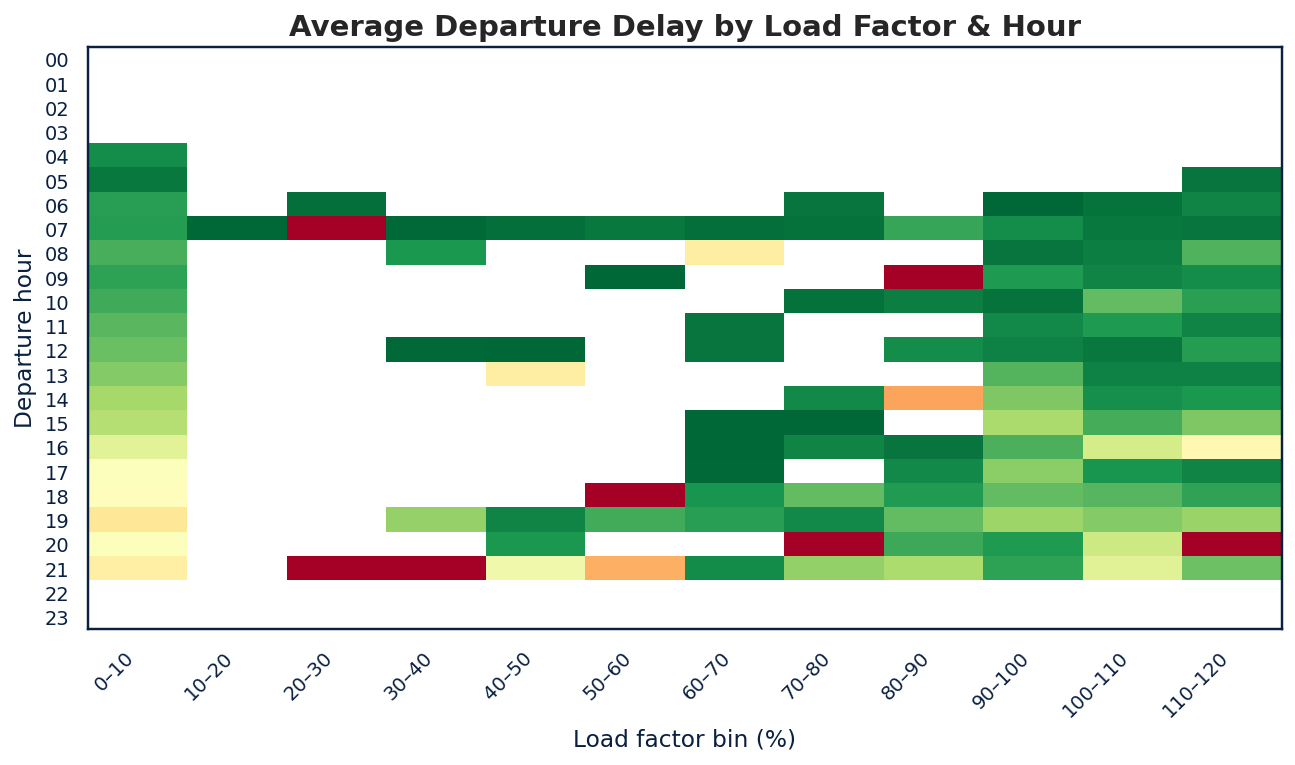

In [33]:
# === Heatmap: Avg Departure Delay by Load Factor (%) × Departure Hour (UA-styled) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# --- Guard ---
if 'master' not in globals():
    raise RuntimeError("`master` is not defined. Run your merge/feature-engineering cell first.")

df = master.copy()

# --- Ensure needed columns ---
# load_factor fallback if missing
if "load_factor" not in df.columns and {"total_pax","total_seats"} <= set(df.columns):
    df["load_factor"] = np.where(pd.to_numeric(df["total_seats"], errors="coerce") > 0,
                                 pd.to_numeric(df["total_pax"], errors="coerce") /
                                 pd.to_numeric(df["total_seats"], errors="coerce"),
                                 np.nan)

for c in ["load_factor","dep_delay_min"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# pick a departure timestamp column (prefer local)
def first_col(cols): 
    return next((c for c in cols if c in df.columns), None)

ts_local = first_col([
    "scheduled_departure_datetime_local",
    "scheduled_departure_time_local",
    "scheduled_departure_local"
])
ts_utc = first_col([
    "scheduled_departure_datetime_utc",
    "scheduled_departure_time_utc",
    "scheduled_departure_time"
])

if ts_local:
    dt = pd.to_datetime(df[ts_local], errors="coerce")  # treat as local clock time
elif ts_utc:
    dt = pd.to_datetime(df[ts_utc], utc=True, errors="coerce")  # UTC time
else:
    raise RuntimeError("No departure timestamp column found (need *_local or *_utc).")

df["_dep_hour"] = dt.dt.hour
df = df.dropna(subset=["_dep_hour","load_factor","dep_delay_min"]).copy()
df["_dep_hour"] = df["_dep_hour"].astype(int)

# --- Bin load factor in percent (0–120% in 10-pp bins to show overbooking cases) ---
df["_lf_pct"] = (df["load_factor"] * 100).clip(0, 120)
bins = np.arange(0, 121, 10)  # 0,10,20,...,120
df["_lf_bin"] = pd.cut(df["_lf_pct"], bins=bins, include_lowest=True, right=False)

# --- Pivot: rows=hour (0–23), cols=LF bins, values=avg delay ---
piv = df.pivot_table(index="_dep_hour", columns="_lf_bin", values="dep_delay_min", aggfunc="mean")
piv = piv.reindex(range(24))  # ensure all hours even if missing

if piv.notna().sum().sum() == 0:
    raise RuntimeError("Heatmap has no data (all NaN after filtering). Check your load_factor and timestamps.")

# --- UA look & plot ---
UA_NAVY="#0A2040"
plt.rcParams.update({
    "figure.dpi":140, "savefig.dpi":300, "savefig.transparent":True,
    "axes.facecolor":"white","figure.facecolor":"white",
    "axes.edgecolor":UA_NAVY,"axes.labelcolor":UA_NAVY,
    "axes.titleweight":"bold","axes.titlesize":15,"axes.labelsize":12,
    "xtick.color":UA_NAVY,"ytick.color":UA_NAVY,
    "grid.color":"#D9E3F0","grid.linestyle":"-","grid.linewidth":0.8,
    "axes.grid":False,"legend.frameon":False,"font.size":11,"font.family":"DejaVu Sans",
})

fig, ax = plt.subplots(figsize=(11,5.4))

# robust color scale using percentiles to avoid outliers skew
vals = piv.values[np.isfinite(piv.values)]
vmin = np.nanpercentile(vals, 5) if vals.size else None
vmax = np.nanpercentile(vals, 95) if vals.size else None

im = ax.imshow(piv.values, aspect="auto", cmap="RdYlGn_r", vmin=vmin, vmax=vmax)

# Y: hours 0–23
ax.set_yticks(np.arange(len(piv.index)))
ax.set_yticklabels([f"{int(h):02d}" for h in piv.index], fontsize=10)
ax.set_ylabel("Departure hour")

# X: LF bin labels like "0–10", "10–20", ...
col_bins = piv.columns.to_list()
xticks = np.arange(len(col_bins))
def bin_label(iv):
    a = int(iv.left); b = int(iv.right)
    return f"{a}–{b}"
ax.set_xticks(xticks)
ax.set_xticklabels([bin_label(iv) for iv in col_bins], rotation=45, ha="right", fontsize=10)
ax.set_xlabel("Load factor bin (%)")

ax.set_title("Average Departure Delay by Load Factor & Hour")

# co


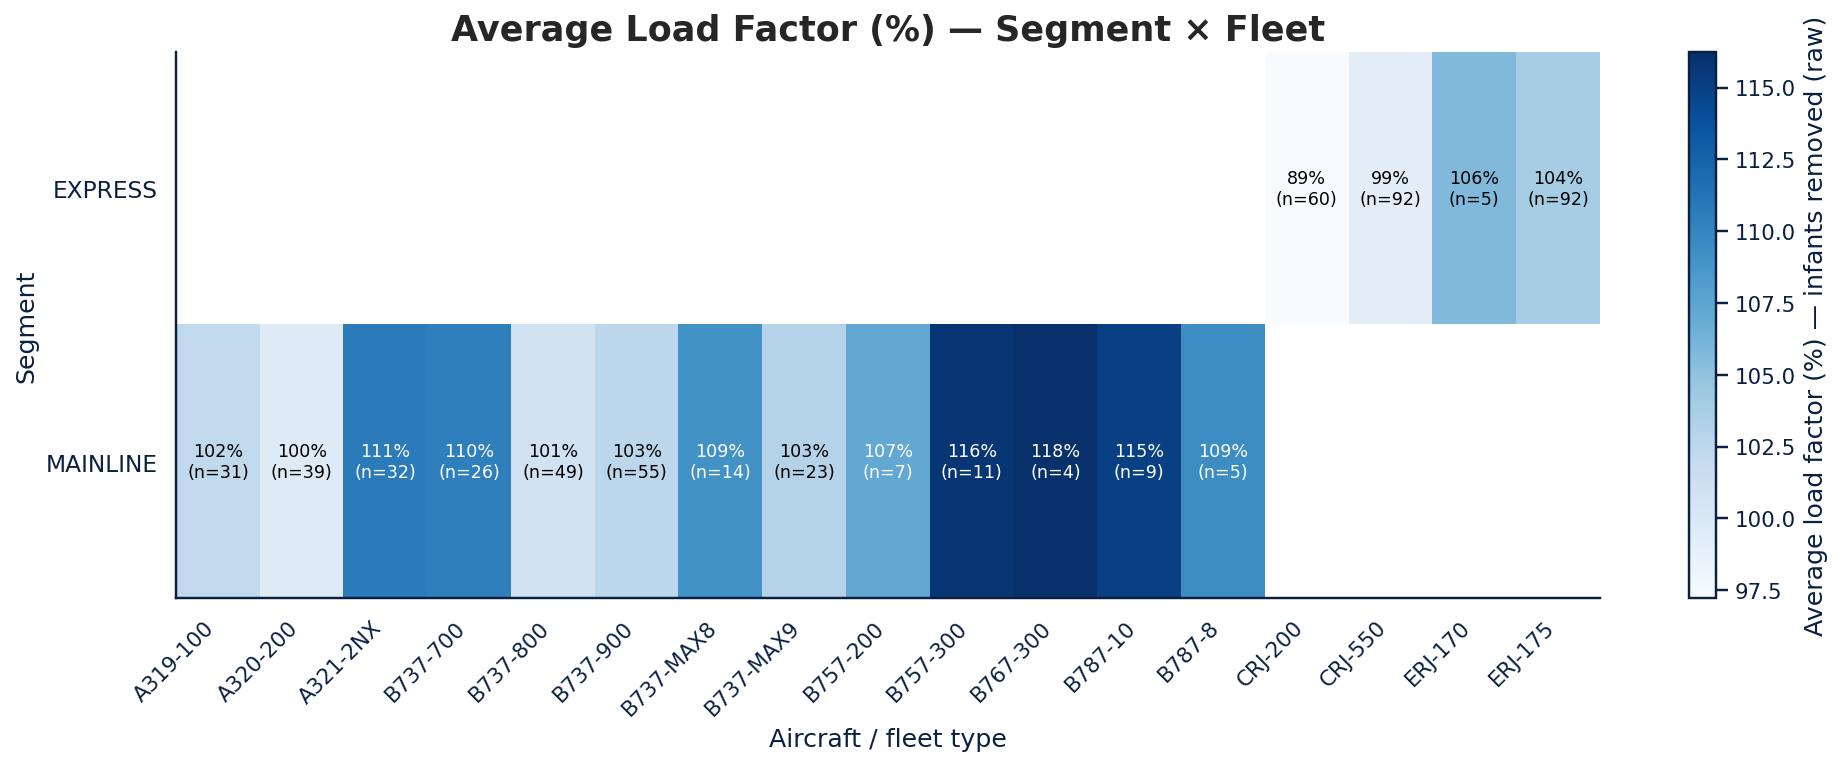

Saved: Loads_heatmap_Segment_x_Fleet_INFANTS_REMOVED_RAW.png


In [50]:
# === Heatmap: Avg Load Factor (%) — Segment × Fleet (INFANTS REMOVED, RAW) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, re

MIN_N  = 3        # hide tiny samples (set 0 to show all)
SHOW_N = True     # show "(n=..)" inside cells

def infer_segment(carrier, fleet):
    MAINLINE_CODES   = {"UA","UAL","UNITED","UNITED AIRLINES"}
    EXPRESS_CARRIERS = {"OO","YX","EV","AX","RP","ZW","C5","G7"}
    EXPRESS_FLEET_RE = re.compile(r"(CRJ|ERJ|E-?17[05]|E-?14[53]|EMB-?14[53]|CRJ-?(200|700|900)|DHC|Q400|DH8)", re.I)
    c = str(carrier or "").upper(); f = str(fleet or "").upper()
    if c.startswith("UA") or c in MAINLINE_CODES: return "MAINLINE"
    if c in EXPRESS_CARRIERS or EXPRESS_FLEET_RE.search(f): return "EXPRESS"
    return "MAINLINE"

def build_key(df):
    need = ["company_id","flight_number","scheduled_departure_date_local",
            "scheduled_departure_station_code","scheduled_arrival_station_code"]
    miss = [c for c in need if c not in df.columns]
    if miss: raise RuntimeError(f"Missing for flight_key: {miss}")
    dep_date = pd.to_datetime(df["scheduled_departure_date_local"], errors="coerce").dt.date.astype(str)
    return (df["company_id"].astype(str).str.upper().str.strip() + "|" +
            df["flight_number"].astype(str).str.strip() + "|" +
            dep_date + "|" +
            df["scheduled_departure_station_code"].astype(str).str.upper().str.strip() + "|" +
            df["scheduled_arrival_station_code"].astype(str).str.upper().str.strip())

def pick_seat_column(df_flt):
    for c in ["flown_seats","available_seats","configured_seats","total_seats"]:
        if c in df_flt.columns: return c
    raise RuntimeError("No seat column found (need one of flown/available/configured/total_seats).")

# --------- Build a flight-level table with INFANTS REMOVED (seated pax) ----------
flt = None

if 'master' in globals() and {"flight_key","carrier","fleet_type"}.issubset(master.columns):
    # Use master if it already has seated pax & seats
    m = master.copy()
    if "seated_pax_flt" in m.columns and "seats_flt" in m.columns:
        base = m[["flight_key","carrier","fleet_type","seated_pax_flt","seats_flt"]].dropna(subset=["seats_flt"])
        flt = base.rename(columns={"seated_pax_flt":"seated_pax", "seats_flt":"seats"})
    elif {"total_pax_flt","lap_child_sum","seats_flt"}.issubset(m.columns):
        base = m[["flight_key","carrier","fleet_type","total_pax_flt","lap_child_sum","seats_flt"]]
        base["seated_pax"] = np.maximum(0, (pd.to_numeric(base["total_pax_flt"], errors="coerce").fillna(0)
                                            - pd.to_numeric(base["lap_child_sum"], errors="coerce").fillna(0)))
        flt = base.rename(columns={"seats_flt":"seats"})[["flight_key","carrier","fleet_type","seated_pax","seats"]]
    # else we’ll fall back to raw tables below if available

if flt is None:
    # Fall back to raw sources: df_pf (PNR+Flight) + df_flt (Flight Level)
    if 'df_pf' not in globals() or 'df_flt' not in globals():
        raise RuntimeError("Need either `master` with seats & pax, or raw `df_pf` + `df_flt` loaded.")
    pf = df_pf.copy(); fl = df_flt.copy()
    pf["flight_key"] = build_key(pf); fl["flight_key"] = build_key(fl)

    # seated passengers per flight = sum(total_pax - lap_child_count), no negatives
    pf["total_pax"] = pd.to_numeric(pf.get("total_pax"), errors="coerce")
    pf["lap_child_count"] = pd.to_numeric(pf.get("lap_child_count", 0), errors="coerce").fillna(0)
    pf["_seated_row"] = np.maximum(0, pf["total_pax"].fillna(0) - pf["lap_child_count"])
    pax = pf.groupby("flight_key", as_index=False).agg(seated_pax=("_seated_row","sum"))

    seat_col = pick_seat_column(fl)
    fl[seat_col] = pd.to_numeric(fl[seat_col], errors="coerce")
    seats = fl[["flight_key","carrier","fleet_type",seat_col]].drop_duplicates().rename(columns={seat_col:"seats"})

    flt = seats.merge(pax, on="flight_key", how="inner")  # only flights with pax
    flt = flt[flt["seats"] > 0].copy()

# compute RAW (uncapped) LF with infants removed
flt["lf_raw"] = pd.to_numeric(flt["seated_pax"], errors="coerce") / pd.to_numeric(flt["seats"], errors="coerce")
flt = flt.replace([np.inf,-np.inf], np.nan).dropna(subset=["lf_raw"])

# Segment flag
flt["segment"] = [infer_segment(c, f) for c, f in zip(flt["carrier"], flt["fleet_type"])]

# --------- Aggregate & pivot for heatmap ----------
agg = (flt.groupby(["segment","fleet_type"], as_index=False)
          .agg(avg_lf_pct=("lf_raw", lambda s: 100*s.mean()),
               n_flights=("flight_key","count")))
agg = agg[agg["n_flights"] >= MIN_N]

pivot = agg.pivot(index="segment", columns="fleet_type", values="avg_lf_pct")
nmap  = agg.pivot(index="segment", columns="fleet_type", values="n_flights")

# --------- Plot (UA-styled) ----------
UA_NAVY="#0A2040"
plt.rcParams.update({
    "figure.dpi":140, "savefig.dpi":300, "savefig.transparent":True,
    "axes.facecolor":"white","figure.facecolor":"white",
    "axes.edgecolor":UA_NAVY,"axes.labelcolor":UA_NAVY,
    "axes.titleweight":"bold","axes.titlesize":18,"axes.labelsize":13,
    "xtick.color":UA_NAVY,"ytick.color":UA_NAVY,
    "axes.grid":False,"font.size":11,"font.family":"DejaVu Sans",
})

h, w = pivot.shape
fig, ax = plt.subplots(figsize=(min(22, max(8, 0.6*w+4)), min(12, max(4.5, 1.8*h+2))))

vals = pivot.values
finite = np.isfinite(vals)
vmin = np.nanpercentile(vals[finite], 5) if finite.any() else 0
vmax = np.nanpercentile(vals[finite],95) if finite.any() else 110  # allow >100 if present
im = ax.imshow(pivot, aspect="auto", cmap="Blues", vmin=vmin, vmax=vmax)

ax.set_yticks(np.arange(h)); ax.set_yticklabels(pivot.index, fontsize=12)
ax.set_xticks(np.arange(w)); ax.set_xticklabels(pivot.columns, rotation=45, ha="right", fontsize=11)
ax.set_xlabel("Aircraft / fleet type"); ax.set_ylabel("Segment")
ax.set_title("Average Load Factor (%) — Segment × Fleet" )

if SHOW_N:
    mid = (vmin+vmax)/2 if finite.any() else 50
    for i in range(h):
        for j in range(w):
            v = pivot.iat[i,j]
            if not np.isnan(v):
                n = int(nmap.iat[i,j]) if not np.isnan(nmap.iat[i,j]) else 0
                ax.text(j, i, f"{v:.0f}%\n(n={n})", ha="center", va="center",
                        color=("black" if v < mid else "white"), fontsize=9)

cbar = plt.colorbar(im, ax=ax); cbar.set_label("Average load factor (%) — infants removed (raw)")
for sp in ["top","right"]: ax.spines[sp].set_visible(False)
plt.tight_layout(); plt.savefig("Loads_heatmap_Segment_x_Fleet_INFANTS_REMOVED_RAW.png", bbox_inches="tight")
plt.show()
print("Saved: Loads_heatmap_Segment_x_Fleet_INFANTS_REMOVED_RAW.png")


In [52]:
# ================= DUPLICATION AUDIT: PNR rows, joins, & seats =================
import pandas as pd, numpy as np

# --- helpers ------------------------------------------------------------------
def build_flight_key(df):
    need = ["company_id","flight_number","scheduled_departure_date_local",
            "scheduled_departure_station_code","scheduled_arrival_station_code"]
    miss = [c for c in need if c not in df.columns]
    if miss: 
        raise RuntimeError(f"Missing for flight_key: {miss}")
    dep_date = pd.to_datetime(df["scheduled_departure_date_local"], errors="coerce").dt.date.astype(str)
    return (df["company_id"].astype(str).str.upper().str.strip() + "|" +
            df["flight_number"].astype(str).str.strip() + "|" +
            dep_date + "|" +
            df["scheduled_departure_station_code"].astype(str).str.upper().str.strip() + "|" +
            df["scheduled_arrival_station_code"].astype(str).str.upper().str.strip())

def pick_seat_cols(df_flt):
    return [c for c in ["flown_seats","available_seats","configured_seats","total_seats"] if c in df_flt.columns]

# --- ensure keys / numeric ----------------------------------------------------
pf = df_pf.copy()
fl = df_flt.copy()
pf["flight_key"] = build_flight_key(pf)
fl["flight_key"] = build_flight_key(fl)

pf["total_pax"]       = pd.to_numeric(pf.get("total_pax"), errors="coerce")
pf["lap_child_count"] = pd.to_numeric(pf.get("lap_child_count", 0), errors="coerce").fillna(0)

seat_cols = pick_seat_cols(fl)
if not seat_cols:
    raise RuntimeError("No seat columns found in df_flt (expected one of flown/available/configured/total_seats).")
for c in seat_cols:
    fl[c] = pd.to_numeric(fl[c], errors="coerce")

# =============== 1) Exact duplicate PNR-flight rows ===========================
print("\n[1] Exact duplicate rows (same flight_key, record_locator, total_pax, lap_child_count)")
subset_cols = [c for c in ["flight_key","record_locator","total_pax","lap_child_count"] if c in pf.columns]
dup_mask_exact = pf.duplicated(subset=subset_cols, keep=False)
n_exact = dup_mask_exact.sum()
print(f"   exact duplicates: {n_exact:,} rows ({100*n_exact/len(pf):.1f}% of df_pf)")
if n_exact:
    display(pf.loc[dup_mask_exact, subset_cols].head(10))

# =============== 2) Duplicate PNR per flight (same PNR appears multiple times) =
print("\n[2] Same PNR repeated on the SAME flight (potential double-count driver)")
if "record_locator" in pf.columns:
    grp_pnr = (pf.groupby(["flight_key","record_locator"], as_index=False)
                 .size().rename(columns={"size":"rows_per_pair"}))
    repeated = grp_pnr[grp_pnr["rows_per_pair"] > 1]
    print(f"   pairs with rows_per_pair > 1: {len(repeated):,}")
    display(repeated.sort_values("rows_per_pair", ascending=False).head(15))
else:
    print("   'record_locator' not in df_pf; skipping PNR repetition check.")

# =============== 3) Pax inflation factor by flight (raw vs de-duplicated) =====
print("\n[3] Pax inflation per flight (raw sum vs 1 row per PNR per flight)")
if "record_locator" in pf.columns:
    # raw pax per flight
    pax_raw = pf.groupby("flight_key", as_index=False)["total_pax"].sum().rename(columns={"total_pax":"pax_sum_raw"})
    # de-dup: for each (flight, PNR) keep the LARGEST total_pax (robust to tiny variations)
    pf_sorted = pf.sort_values(["flight_key","record_locator","total_pax"], ascending=[True,True,False])
    pf_dedup  = pf_sorted.drop_duplicates(subset=["flight_key","record_locator"])
    pax_dedup = pf_dedup.groupby("flight_key", as_index=False)["total_pax"].sum().rename(columns={"total_pax":"pax_sum_dedup"})
    # join and compute factor
    pax_cmp = pax_raw.merge(pax_dedup, on="flight_key", how="left")
    pax_cmp["pax_inflation_factor"] = pax_cmp["pax_sum_raw"] / pax_cmp["pax_sum_dedup"]
    pax_cmp = pax_cmp.replace([np.inf,-np.inf], np.nan)

    print("   flights with pax_inflation_factor > 1.05 (likely double-count):")
    bad = pax_cmp[pax_cmp["pax_inflation_factor"] > 1.05].sort_values("pax_inflation_factor", ascending=False)
    print(f"   count = {len(bad):,} ({100*len(bad)/len(pax_cmp):.1f}% of flights with PNR data)")
    display(bad.head(20))
else:
    print("   'record_locator' not in df_pf; skipping pax inflation check.")

# =============== 4) Seat inconsistency per flight =============================
# --- [4] Seat inconsistency by flight (robust, no duplicate-index error) -----
print("\n[4] Seat inconsistency by flight (robust)")

seat_cols = [c for c in ["flown_seats","available_seats","configured_seats","total_seats"]
             if c in df_flt.columns]
if not seat_cols:
    raise RuntimeError("No seat columns found (need one of flown/available/configured/total_seats).")

# unique rows by (flight_key + seat fields); flights can still appear multiple times
base = (df_flt[["flight_key"] + seat_cols]
        .dropna(how="all", subset=seat_cols)
        .drop_duplicates())

# 1) for each flight, how many distinct values did each seat column take?
nuniq = base.groupby("flight_key")[seat_cols].nunique()

# 2) for each flight, min and max across ALL seat fields and ALL rows for that flight
#    (group first, THEN reduce across columns → index is unique)
seats_min = base.groupby("flight_key")[seat_cols].min().min(axis=1)
seats_max = base.groupby("flight_key")[seat_cols].max().max(axis=1)

# assemble result
seats_all = nuniq.copy()
seats_all["seats_min"] = seats_min
seats_all["seats_max"] = seats_max
seats_all = seats_all.reset_index()

# any seat column changed across rows? (nunique > 1)
conflict = seats_all[(seats_all[seat_cols].gt(1)).any(axis=1)]
print(f"   flights with conflicting seat values across rows: {len(conflict):,}")
display(conflict[["flight_key","seats_min","seats_max"] + seat_cols].head(20))

share_conflict = 100 * len(conflict) / len(seats_all)
print(f"   share of flights with ≥1 seat column changing across rows: {share_conflict:.1f}%")


# =============== 5) Does duplication after MERGE exist? (master row explosion) =
print("\n[5] Master merge explosion check (if you have a `master` table)")
if "master" in globals():
    dup_master = master.groupby("flight_key").size().rename("rows_per_flight").reset_index()
    exploded = dup_master[dup_master["rows_per_flight"] > 1]
    print(f"   flights with >1 row in `master`: {len(exploded):,} (should be 0 if built via pre-aggregation)")
    display(exploded.head(20))
else:
    print("   `master` not found; skipping merge explosion check.")

# =============== 6) Do duplicates explain >100% LF? ===========================
print("\n[6] Tie it together: raw vs de-dup LF (using a robust seat denominator)")
# best seats = max across seat columns
base_seats = (fl[["flight_key"] + seat_cols].drop_duplicates()
                .groupby("flight_key")[seat_cols].max().rename(columns=lambda c: f"max_{c}"))
base_seats["best_seats"] = base_seats.max(axis=1)
base_seats = base_seats.reset_index()[["flight_key","best_seats"]]

# raw pax and dedup pax from step (3)
if "record_locator" in pf.columns:
    pax_cmp2 = pax_cmp.merge(base_seats, on="flight_key", how="left")
    # build LFs
    pax_cmp2 = pax_cmp2[pax_cmp2["best_seats"] > 0].copy()
    pax_cmp2["lf_raw"]   = pax_cmp2["pax_sum_raw"]   / pax_cmp2["best_seats"]
    pax_cmp2["lf_dedup"] = pax_cmp2["pax_sum_dedup"] / pax_cmp2["best_seats"]
    # offenders that drop back <=100% after de-dup (clear duplication)
    fixed = pax_cmp2[(pax_cmp2["lf_raw"] > 1.02) & (pax_cmp2["lf_dedup"] <= 1.00)]
    still = pax_cmp2[(pax_cmp2["lf_dedup"] > 1.02)]
    print(f"   flights >100% LF (raw) that become ≤100% after de-dup: {len(fixed):,}")
    display(fixed.sort_values("lf_raw", ascending=False).head(20)[
        ["flight_key","pax_sum_raw","pax_sum_dedup","best_seats","lf_raw","lf_dedup"]
    ])
    print(f"   flights still >100% even after de-dup (likely seat denominator issue): {len(still):,}")
    display(still.sort_values("lf_dedup", ascending=False).head(20)[
        ["flight_key","pax_sum_dedup","best_seats","lf_dedup"]
    ])
else:
    print("   need 'record_locator' to compare raw vs de-dup LF.")



[1] Exact duplicate rows (same flight_key, record_locator, total_pax, lap_child_count)
   exact duplicates: 73,457 rows (10.7% of df_pf)


,flight_key,record_locator,total_pax,lap_child_count
2,UA|1620|2025-08-01|ORD|SEA,PNR_296108,4,0
4,UA|1620|2025-08-01|ORD|SEA,PNR_296108,4,0
5,UA|1620|2025-08-01|ORD|SEA,PNR_296108,4,0
15,UA|907|2025-08-01|ORD|FRA,PNR_13593,4,0
16,UA|907|2025-08-01|ORD|FRA,PNR_13593,4,0
19,UA|2424|2025-08-07|ORD|RDU,PNR_204458,5,0
20,UA|2424|2025-08-07|ORD|RDU,PNR_204458,5,0
21,UA|2424|2025-08-07|ORD|RDU,PNR_204458,5,0
38,UA|2099|2025-08-04|ORD|IAH,PNR_32255,4,0
39,UA|2099|2025-08-04|ORD|IAH,PNR_32255,4,0



[2] Same PNR repeated on the SAME flight (potential double-count driver)
   pairs with rows_per_pair > 1: 36,664


,flight_key,record_locator,rows_per_pair
412714,UA|2385|2025-08-06|ORD|MSO,PNR_51815,5
283798,UA|1848|2025-08-02|ORD|ATL,PNR_42629,5
147156,UA|1182|2025-08-09|ORD|SJC,PNR_576878,5
231363,UA|1620|2025-08-03|ORD|SEA,PNR_506125,5
221171,UA|1584|2025-08-10|ORD|LAX,PNR_174012,5
189042,UA|1387|2025-08-09|ORD|SFO,PNR_183327,5
479562,UA|275|2025-08-10|ORD|RAP,PNR_429569,5
58365,OO|5290|2025-08-04|ORD|BOI,PNR_555667,4
159381,UA|1269|2025-08-01|ORD|CLE,PNR_266047,4
344177,UA|2133|2025-08-05|ORD|EWR,PNR_282559,4



[3] Pax inflation per flight (raw sum vs 1 row per PNR per flight)
   flights with pax_inflation_factor > 1.05 (likely double-count):
   count = 6,364 (78.9% of flights with PNR data)


,flight_key,pax_sum_raw,pax_sum_dedup,pax_inflation_factor
1611,OO|5289|2025-08-09|ORD|CRW,81,41,1.975610
1416,OO|5229|2025-08-02|ORD|ILM,144,75,1.920000
5549,UA|2323|2025-08-09|ORD|MCO,379,198,1.914141
1259,OO|5122|2025-08-02|ORD|EAU,75,40,1.875000
1138,OO|5045|2025-08-02|ORD|RHI,75,41,1.829268
2025,OO|5447|2025-08-09|ORD|PVD,98,54,1.814815
7886,YX|3638|2025-08-09|ORD|CHS,130,72,1.805556
1097,OO|5026|2025-08-09|ORD|JST,27,15,1.800000
5542,UA|2323|2025-08-02|ORD|MCO,355,200,1.775000
3891,UA|1538|2025-08-09|ORD|SAV,220,124,1.774194



[4] Seat inconsistency by flight (robust)
   flights with conflicting seat values across rows: 90


,flight_key,seats_min,seats_max,total_seats
789,OO|4712|NaT|ORD|ELP,70,76,2
797,OO|4718|NaT|ORD|DAY,50,70,2
877,OO|4789|NaT|ORD|FAR,70,76,2
1221,OO|5225|NaT|ORD|MKE,50,76,2
1476,OO|5337|NaT|ORD|ROA,70,76,2
1580,OO|5376|NaT|ORD|LEX,70,76,2
1624,OO|5392|NaT|ORD|OKC,70,76,2
1636,OO|5395|NaT|ORD|GSO,70,76,2
1668,OO|5414|NaT|ORD|MEM,50,76,2
1680,OO|5420|NaT|ORD|MLI,50,76,2


   share of flights with ≥1 seat column changing across rows: 1.3%

[5] Master merge explosion check (if you have a `master` table)
   flights with >1 row in `master`: 90 (should be 0 if built via pre-aggregation)


,flight_key,rows_per_flight
789,OO|4712|NaT|ORD|ELP,2
797,OO|4718|NaT|ORD|DAY,2
877,OO|4789|NaT|ORD|FAR,2
1221,OO|5225|NaT|ORD|MKE,2
1476,OO|5337|NaT|ORD|ROA,2
1580,OO|5376|NaT|ORD|LEX,2
1624,OO|5392|NaT|ORD|OKC,2
1636,OO|5395|NaT|ORD|GSO,2
1668,OO|5414|NaT|ORD|MEM,2
1680,OO|5420|NaT|ORD|MLI,2



[6] Tie it together: raw vs de-dup LF (using a robust seat denominator)
   flights >100% LF (raw) that become ≤100% after de-dup: 319


,flight_key,pax_sum_raw,pax_sum_dedup,best_seats,lf_raw,lf_dedup
3890,UA|1538|2025-08-08|ORD|SAV,188,119,126.0,1.492063,0.944444
4564,UA|1857|2025-08-08|ORD|MIA,243,166,166.0,1.463855,1.000000
1291,OO|5125|2025-08-08|ORD|CMX,72,47,50.0,1.440000,0.940000
1481,OO|5251|2025-08-08|ORD|ASE,100,70,70.0,1.428571,1.000000
7097,UA|739|2025-08-08|ORD|BZN,179,123,126.0,1.420635,0.976190
5548,UA|2323|2025-08-08|ORD|MCO,283,200,200.0,1.415000,1.000000
928,OO|4739|2025-08-08|ORD|GRB,70,50,50.0,1.400000,1.000000
2861,OO|5930|2025-08-08|ORD|FAR,70,50,50.0,1.400000,1.000000
4508,UA|1834|2025-08-08|ORD|TPA,232,163,166.0,1.397590,0.981928
3625,UA|1363|2025-08-08|ORD|LAX,279,198,200.0,1.395000,0.990000


   flights still >100% even after de-dup (likely seat denominator issue): 0


,flight_key,pax_sum_dedup,best_seats,lf_dedup


[DEDUP] PNR rows: 687,878 → 644,315 (removed 43,563)
[BUILD] flights with PAX & seats: 556 | share LF>100%: 0.4%


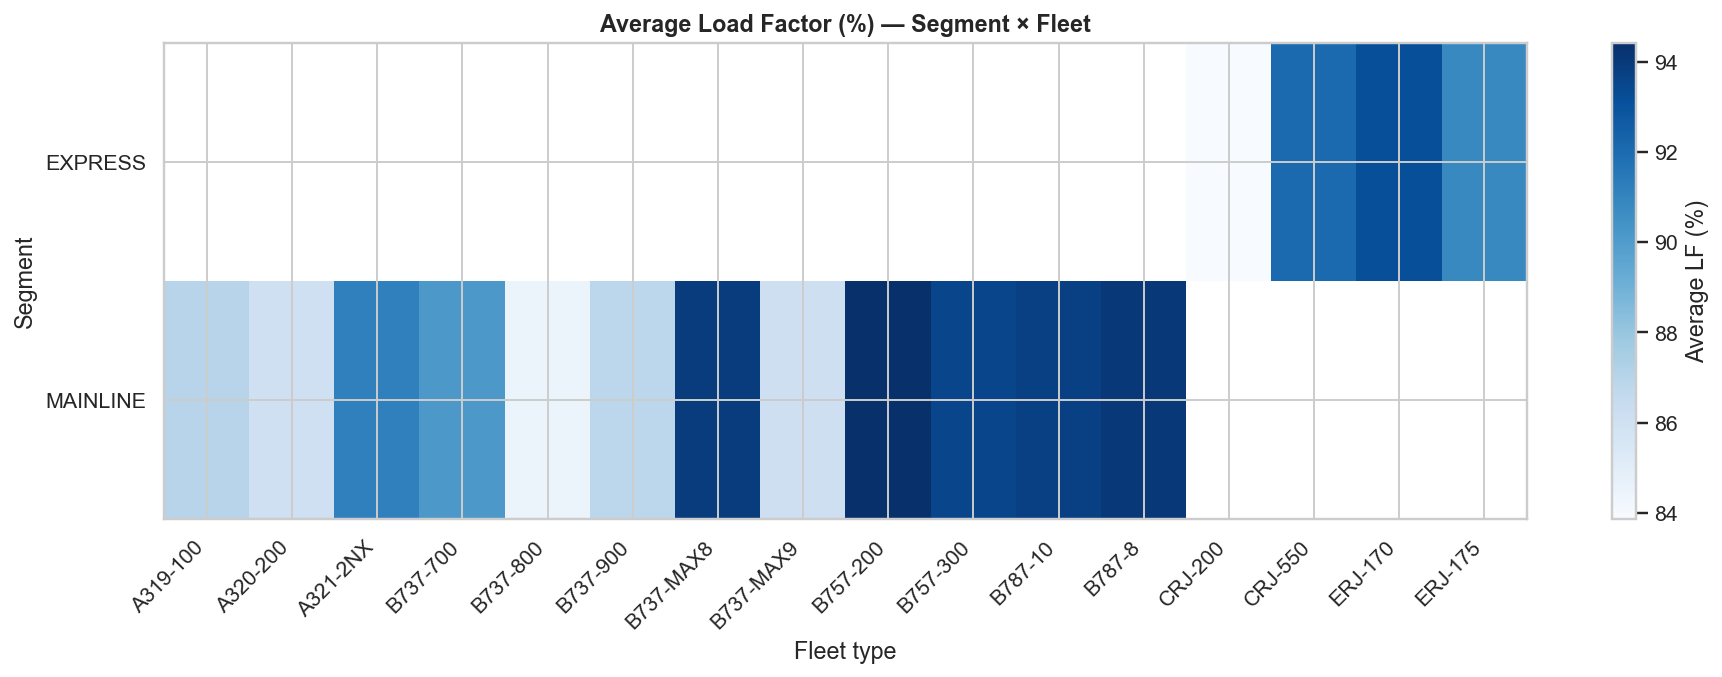


Kept flight-level table in variable: flt_q4 (columns: flight_key, carrier, fleet_type, segment, seated_pax, best_seats, load_factor)


In [54]:
# ===================== STEP 4A: Clean loads table + "How do loads compare?" =====================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, re

sns.set_theme(context="notebook", style="whitegrid")

# ---------- helpers ----------
def build_key(df):
    need = ["company_id","flight_number","scheduled_departure_date_local",
            "scheduled_departure_station_code","scheduled_arrival_station_code"]
    miss = [c for c in need if c not in df.columns]
    if miss: raise RuntimeError(f"Missing for flight_key: {miss}")
    dep_date = pd.to_datetime(df["scheduled_departure_date_local"], errors="coerce").dt.date.astype(str)
    return (df["company_id"].astype(str).str.upper().str.strip() + "|" +
            df["flight_number"].astype(str).str.strip() + "|" +
            dep_date + "|" +
            df["scheduled_departure_station_code"].astype(str).str.upper().str.strip() + "|" +
            df["scheduled_arrival_station_code"].astype(str).str.upper().str.strip())

def pick_seat_cols(df_flt):
    return [c for c in ["flown_seats","available_seats","configured_seats","total_seats"] if c in df_flt.columns]

def infer_segment(carrier, fleet):
    MAINLINE={"UA","UAL","UNITED","UNITED AIRLINES"}
    EXPRESS={"OO","YX","EV","AX","RP","ZW","C5","G7"}
    EXP_RE=re.compile(r"(CRJ|ERJ|E-?17[05]|E-?14[53]|EMB-?14[53]|CRJ-?(200|700|900)|DHC|Q400|DH8)", re.I)
    c=str(carrier or "").upper(); f=str(fleet or "").upper()
    if c.startswith("UA") or c in MAINLINE: return "MAINLINE"
    if c in EXPRESS or EXP_RE.search(f):     return "EXPRESS"
    return "MAINLINE"

# ---------- 1) De-duplicate PNRs & build seated passengers (INFANTS REMOVED) ----------
pf = df_pf.copy()
pf["flight_key"] = build_key(pf)
pf["total_pax"]       = pd.to_numeric(pf.get("total_pax"), errors="coerce")
pf["lap_child_count"] = pd.to_numeric(pf.get("lap_child_count", 0), errors="coerce").fillna(0)

if "record_locator" not in pf.columns:
    raise RuntimeError("`df_pf` must have `record_locator` to de-duplicate PNR rows.")

# keep one row per (flight_key, PNR), taking the LARGEST total_pax
before = len(pf)
pf = (pf.sort_values(["flight_key","record_locator","total_pax"], ascending=[True,True,False])
        .drop_duplicates(subset=["flight_key","record_locator"]))
after  = len(pf)
print(f"[DEDUP] PNR rows: {before:,} → {after:,} (removed {before-after:,})")

# seated pax per flight (infants removed)
pf["_seated_row"] = np.maximum(0, pf["total_pax"].fillna(0) - pf["lap_child_count"])
pax_flt = pf.groupby("flight_key", as_index=False).agg(seated_pax=("_seated_row","sum"))

# ---------- 2) Seats & attributes from Flight Level ----------
fl = df_flt.copy()
fl["flight_key"] = build_key(fl)

# best denominator = MAX across any seat fields present
seat_cols = pick_seat_cols(fl)
if not seat_cols: raise RuntimeError("No seat columns in df_flt (need flown/available/configured/total_seats).")
for c in seat_cols: fl[c] = pd.to_numeric(fl[c], errors="coerce")

seats = (fl[["flight_key","carrier","fleet_type"] + seat_cols]
         .drop_duplicates()
         .groupby("flight_key")[seat_cols].max())      # max per column across rows
seats["best_seats"] = seats.max(axis=1)               # max across columns
seats = seats.reset_index()[["flight_key","best_seats"]]
seats = seats[seats["best_seats"] > 0]

# carrier / fleet for grouping
meta = fl[["flight_key","carrier","fleet_type"]].drop_duplicates()

# ---------- 3) Build flight-level loads table ----------
flt_q4 = seats.merge(pax_flt, on="flight_key", how="inner") \
              .merge(meta,    on="flight_key", how="left")

flt_q4["segment"]     = [infer_segment(c,f) for c,f in zip(flt_q4["carrier"], flt_q4["fleet_type"])]
flt_q4["load_factor"] = flt_q4["seated_pax"] / flt_q4["best_seats"]     # RAW, infants removed

# hygiene for analysis
flt_q4 = flt_q4.replace([np.inf,-np.inf], np.nan).dropna(subset=["load_factor"])
print(f"[BUILD] flights with PAX & seats: {len(flt_q4):,} | share LF>100%: {(100*(flt_q4['load_factor']>1).mean()):.1f}%")






# (e) OPTIONAL: Heatmap of avg LF by Segment × Fleet (hide tiny groups)
MIN_N = 5
agg_hm = (flt_q4.groupby(["segment","fleet_type"], as_index=False)
              .agg(avg_lf_pct=("load_factor", lambda s: 100*s.mean()),
                   n=("flight_key","count")))
agg_hm = agg_hm[agg_hm["n"]>=MIN_N]
if not agg_hm.empty:
    p = agg_hm.pivot(index="segment", columns="fleet_type", values="avg_lf_pct")
    h,w = p.shape
    fig, ax = plt.subplots(figsize=(min(22, max(8, 0.6*w+4)), min(10, max(4.5, 1.5*h+2))))
    vals = p.values; finite = np.isfinite(vals)
    vmin = np.nanpercentile(vals[finite], 5) if finite.any() else 0
    vmax = np.nanpercentile(vals[finite],95) if finite.any() else 110
    im = ax.imshow(p, aspect="auto", cmap="Blues", vmin=vmin, vmax=vmax)
    ax.set_yticks(np.arange(h)); ax.set_yticklabels(p.index)
    ax.set_xticks(np.arange(w)); ax.set_xticklabels(p.columns, rotation=45, ha="right")
    ax.set_xlabel("Fleet type"); ax.set_ylabel("Segment")
    ax.set_title("Average Load Factor (%) — Segment × Fleet")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Average LF (%)")
    plt.tight_layout(); plt.show()

# Keep for Step 4B
print("\nKept flight-level table in variable: flt_q4 (columns: flight_key, carrier, fleet_type, segment, seated_pax, best_seats, load_factor)")


[Q4] Pearson r(load_factor, dep_delay_min)  = -0.188
[Q4] Spearman ρ(load_factor, dep_delay_min) = -0.100
[Q4] N used = 556 flights


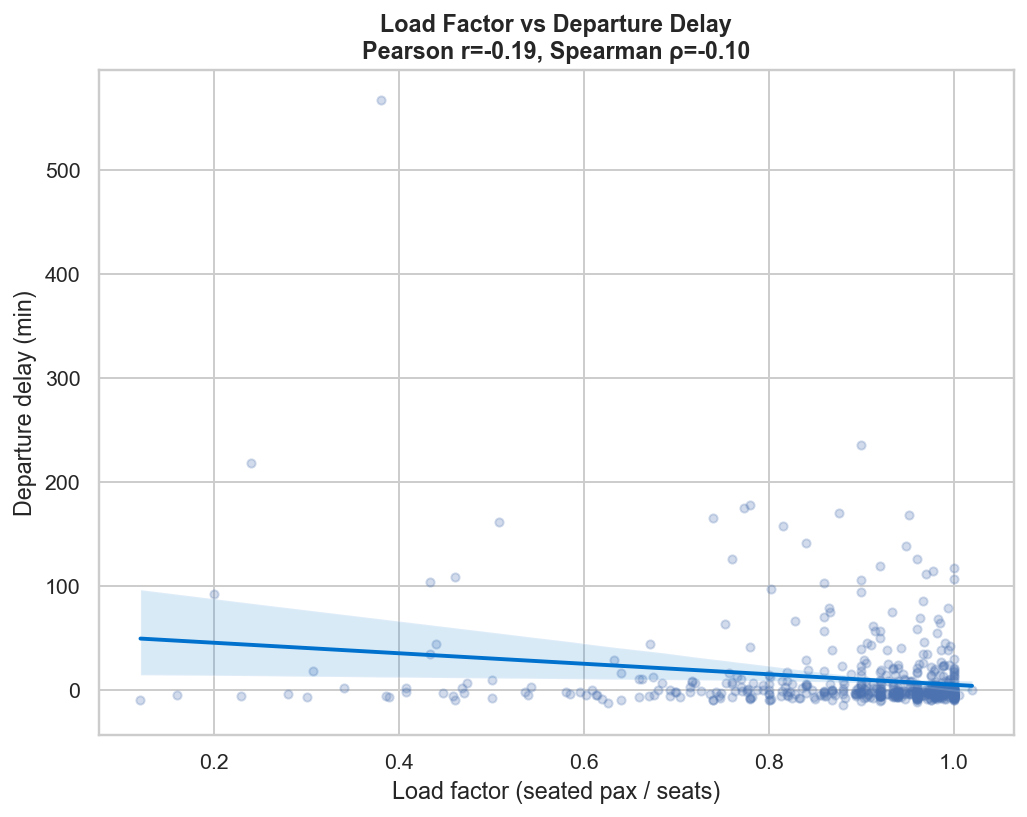

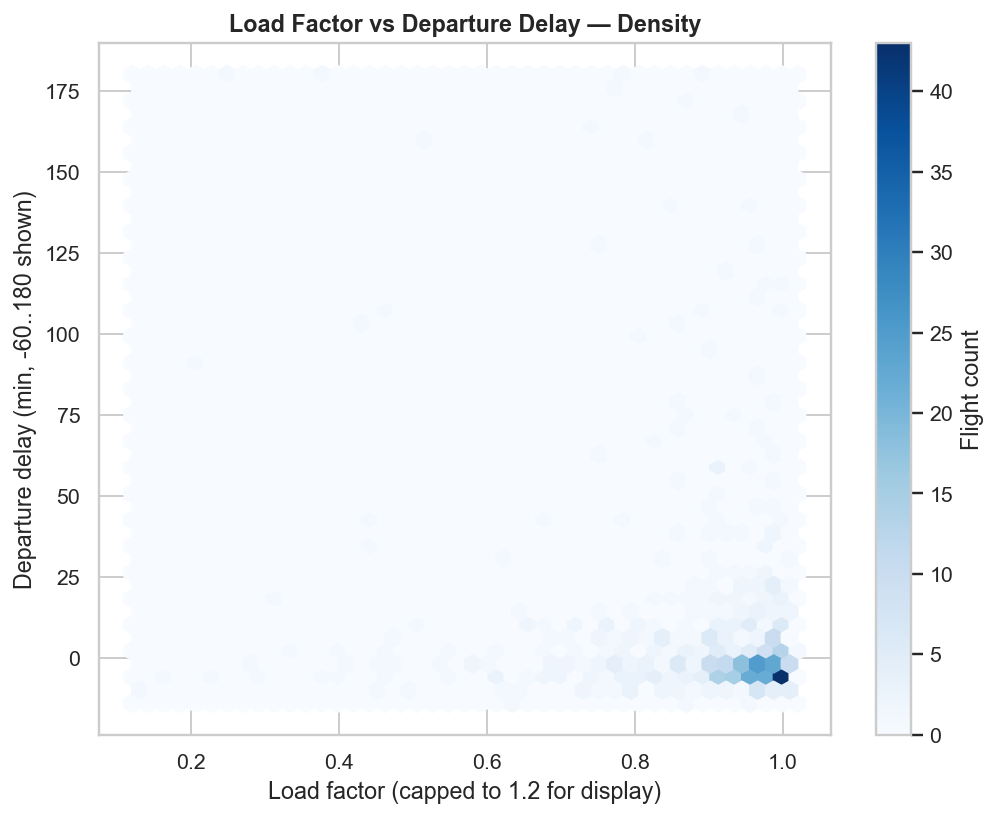

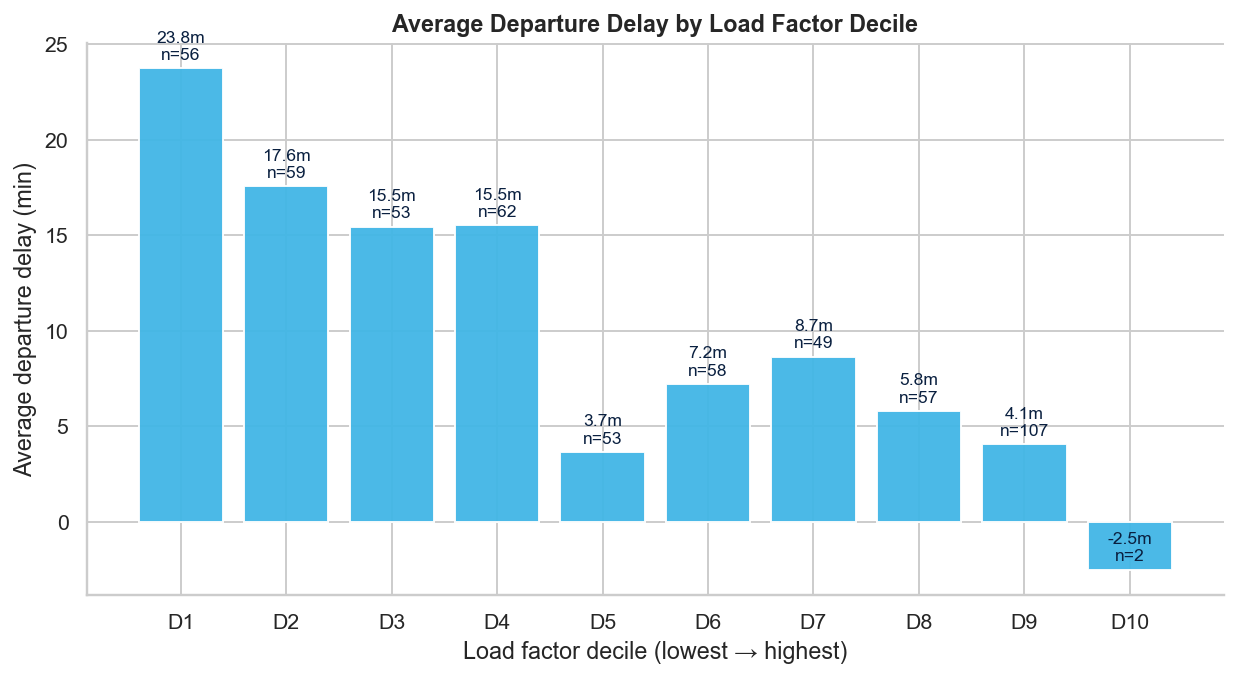

In [55]:
# ===================== STEP 4B: Do higher loads correlate with difficulty? =====================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")
UA_NAVY="#0A2040"; UA_SKY="#41B6E6"; UA_MID="#0072CE"

# --- Bring departure delay per flight (median if multiple rows) ---
fl = df_flt.copy()
fl["flight_key"] = (df_flt["company_id"].astype(str).str.upper().str.strip() + "|" +
                    df_flt["flight_number"].astype(str).str.strip() + "|" +
                    pd.to_datetime(df_flt["scheduled_departure_date_local"], errors="coerce").dt.date.astype(str) + "|" +
                    df_flt["scheduled_departure_station_code"].astype(str).str.upper().str.strip() + "|" +
                    df_flt["scheduled_arrival_station_code"].astype(str).str.upper().str.strip())

# Build dep_delay_min if missing
if "dep_delay_min" not in fl.columns:
    for c in ["scheduled_departure_datetime_local","actual_departure_datetime_local"]:
        fl[c] = pd.to_datetime(fl[c], errors="coerce", utc=True) if c in fl.columns else pd.NaT
    if {"scheduled_departure_datetime_local","actual_departure_datetime_local"} <= set(fl.columns):
        ddiff = fl["actual_departure_datetime_local"] - fl["scheduled_departure_datetime_local"]
        fl["dep_delay_min"] = ddiff.dt.total_seconds()/60.0

dep = (fl.groupby("flight_key", as_index=False)["dep_delay_min"]
         .median()
         .rename(columns={"dep_delay_min":"dep_delay_min"}))

# Merge with loads from Step 4A
if 'flt_q4' not in globals():
    raise RuntimeError("Run Step 4A first to create `flt_q4`.")
d = flt_q4.merge(dep, on="flight_key", how="left").dropna(subset=["dep_delay_min"]).copy()

# --- Correlations ---
pearson  = d[["load_factor","dep_delay_min"]].corr(method="pearson").iloc[0,1]
spearman = d[["load_factor","dep_delay_min"]].corr(method="spearman").iloc[0,1]
print(f"[Q4] Pearson r(load_factor, dep_delay_min)  = {pearson:.3f}")
print(f"[Q4] Spearman ρ(load_factor, dep_delay_min) = {spearman:.3f}")
print(f"[Q4] N used = {len(d):,} flights")

# --- Regression scatter ---
plt.figure(figsize=(7.5,6))
sns.regplot(data=d, x="load_factor", y="dep_delay_min",
            scatter_kws=dict(alpha=0.25, s=18), line_kws=dict(color=UA_MID, lw=2))
plt.xlabel("Load factor (seated pax / seats)")
plt.ylabel("Departure delay (min)")
plt.title(f"Load Factor vs Departure Delay\nPearson r={pearson:.2f}, Spearman ρ={spearman:.2f}")
plt.tight_layout(); plt.show()

# --- Density (hexbin) to show structure on big data ---
plt.figure(figsize=(7.5,6))
hb = plt.hexbin(d["load_factor"].clip(0,1.2), d["dep_delay_min"].clip(-60, 180), gridsize=42, cmap="Blues")
plt.colorbar(hb, label="Flight count")
plt.xlabel("Load factor (capped to 1.2 for display)")
plt.ylabel("Departure delay (min, -60..180 shown)")
plt.title("Load Factor vs Departure Delay — Density")
plt.tight_layout(); plt.show()

# --- Deciles of load factor vs average delay ---
q = pd.qcut(d["load_factor"], q=10, duplicates="drop")
dec = (d.assign(lf_decile=q)
         .groupby("lf_decile", observed=True, as_index=False)
         .agg(avg_delay_min=("dep_delay_min","mean"),
              median_delay_min=("dep_delay_min","median"),
              flights=("flight_key","count")))
dec["decile_index"] = range(1, len(dec)+1)

fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(dec["decile_index"], dec["avg_delay_min"], color=UA_SKY, alpha=0.95, edgecolor="white")
for i,(y,n) in enumerate(zip(dec["avg_delay_min"], dec["flights"]), start=1):
    ax.annotate(f"{y:.1f}m\nn={n}", (i, y), ha="center", va="bottom", fontsize=9, color=UA_NAVY, xytext=(0,3), textcoords="offset points")
ax.set_xticks(dec["decile_index"]); ax.set_xticklabels([f"D{i}" for i in dec["decile_index"]])
ax.set_xlabel("Load factor decile (lowest → highest)")
ax.set_ylabel("Average departure delay (min)")
ax.set_title("Average Departure Delay by Load Factor Decile")
for sp in ["top","right"]: ax.spines[sp].set_visible(False)
plt.tight_layout(); plt.show()


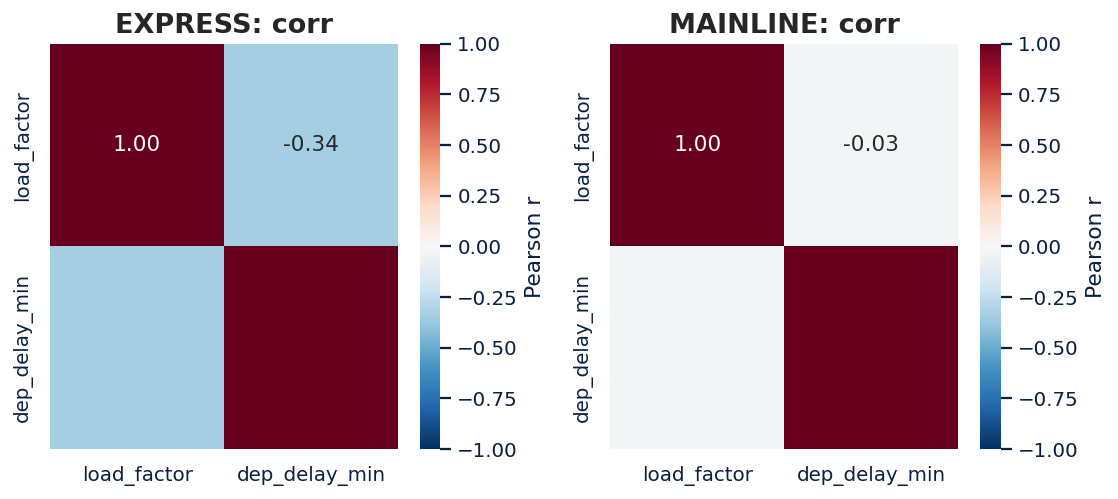

In [62]:
# ==== Q4-B (simple++): correlation + joint heatmaps + decile heatmap =========
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# -- Build analysis table: per-flight load_factor + dep_delay_min --------------
if 'flt_q4' not in globals():
    raise RuntimeError("Run Step 4A first to create `flt_q4`.")

fl = df_flt.copy()
fl["flight_key"] = (fl["company_id"].astype(str).str.upper().str.strip() + "|" +
                    fl["flight_number"].astype(str).str.strip() + "|" +
                    pd.to_datetime(fl["scheduled_departure_date_local"], errors="coerce").dt.date.astype(str) + "|" +
                    fl["scheduled_departure_station_code"].astype(str).str.upper().str.strip() + "|" +
                    fl["scheduled_arrival_station_code"].astype(str).str.upper().str.strip())

# make dep_delay_min if missing
if "dep_delay_min" not in fl.columns:
    for c in ["scheduled_departure_datetime_local","actual_departure_datetime_local"]:
        if c in fl.columns:
            fl[c] = pd.to_datetime(fl[c], errors="coerce", utc=True)
    if {"scheduled_departure_datetime_local","actual_departure_datetime_local"} <= set(fl.columns):
        ddiff = fl["actual_departure_datetime_local"] - fl["scheduled_departure_datetime_local"]
        fl["dep_delay_min"] = ddiff.dt.total_seconds()/60.0

dep = fl.groupby("flight_key", as_index=False)["dep_delay_min"].median()

# merge & clean
d = (flt_q4.merge(dep, on="flight_key", how="left")
          .dropna(subset=["load_factor","dep_delay_min"])
          .copy())

# easy plotting columns
d["load_plot"]  = d["load_factor"].clip(0, 1.2)
d["delay_plot"] = d["dep_delay_min"].clip(-60, 180)
if "segment" not in d.columns:
    d["segment"] = "ALL"

# UA-ish minimal style
UA_NAVY="#0A2040"; UA_SKY="#41B6E6"
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams.update({
    "figure.dpi":130, "savefig.dpi":300, "savefig.transparent":True,
    "axes.facecolor":"white","figure.facecolor":"white",
    "axes.edgecolor":UA_NAVY,"axes.labelcolor":UA_NAVY,
    "axes.titleweight":"bold","axes.titlesize":15,"axes.labelsize":12,
    "xtick.color":UA_NAVY,"ytick.color":UA_NAVY, "grid.color":"#D9E3F0",
    "legend.frameon":False, "font.family":"DejaVu Sans",
})



# ---------- 2) Segment-split mini correlation heatmaps -----------------------
segs = sorted(d["segment"].unique().tolist())[:2]  # show up to 2 segments cleanly
fig, axes = plt.subplots(1, len(segs), figsize=(4.4*len(segs), 4), sharex=False, sharey=False)
if len(segs)==1: axes = [axes]
for ax, seg in zip(axes, segs):
    ds = d[d["segment"]==seg]
    cseg = ds[["load_factor","dep_delay_min"]].corr(method="pearson")
    sns.heatmap(cseg, vmin=-1, vmax=1, center=0, cmap="RdBu_r", annot=True, fmt=".2f",
                cbar_kws={"label":"Pearson r"}, ax=ax)
    ax.set_title(f"{seg}: corr")
plt.tight_layout(); plt.show()



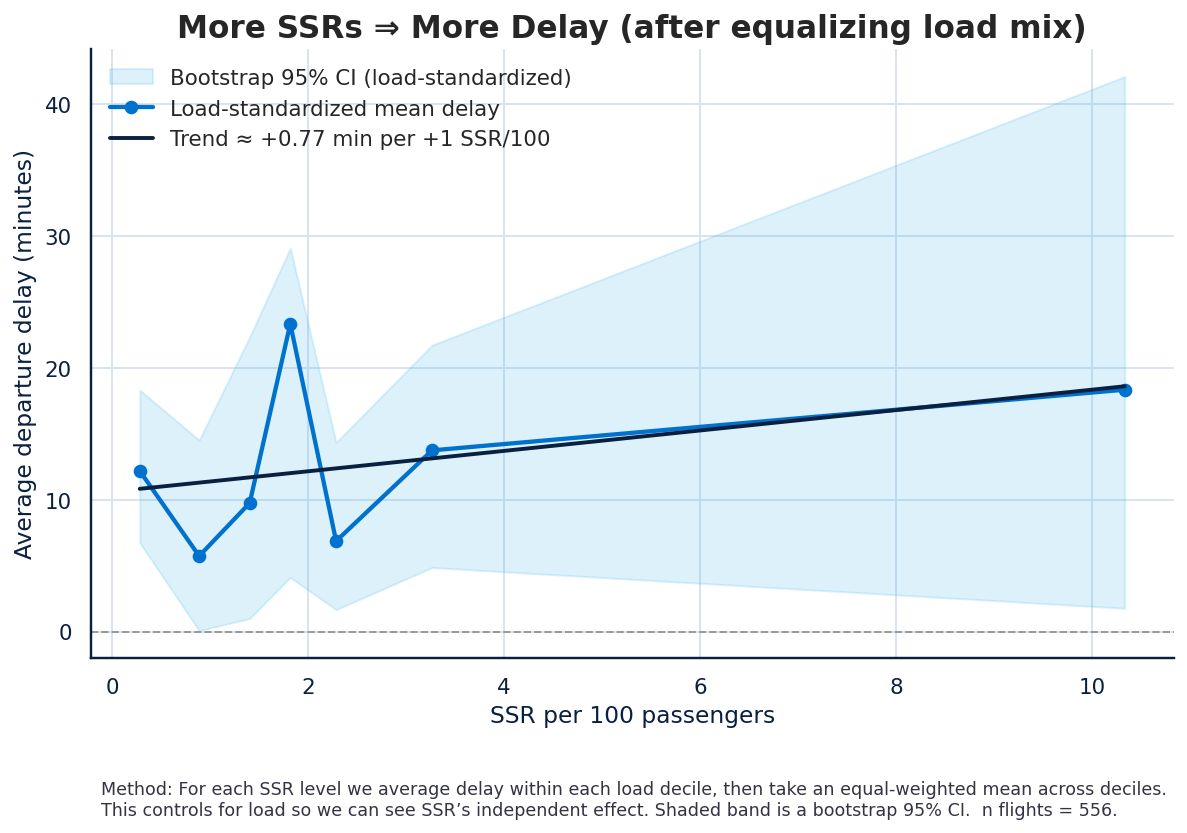

In [73]:
# === Q5: One easy, exec-friendly chart (Load-standardized delay vs SSR) ======
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# ---- Guard ----
need = {"dep_delay_min","load_factor","ssr_per_100"}
if 'ssr' not in globals() or not need.issubset(ssr.columns):
    raise RuntimeError("Run the Q5 prep first to create `ssr` with dep_delay_min, load_factor, ssr_per_100.")

d = ssr.dropna(subset=["dep_delay_min","load_factor","ssr_per_100"]).copy()

# ---- Settings ----
LF_DECILES = 10         # how finely we equalize the load mix
SSR_BINS   = 8          # how many SSR bins across x-axis
BOOT_N     = 300        # bootstrap draws for CI
SAVE       = True

# ---- UA-ish style ----
UA_NAVY="#0A2040"; UA_SKY="#41B6E6"; UA_MID="#0072CE"; UA_LIGHT="#9BD3F7"; UA_GOLD="#F6BE00"
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams.update({
    "figure.dpi":140,"savefig.dpi":300,"savefig.transparent":True,
    "axes.facecolor":"white","figure.facecolor":"white","axes.edgecolor":UA_NAVY,
    "axes.labelcolor":UA_NAVY,"axes.titlesize":16,"axes.titleweight":"bold",
    "xtick.color":UA_NAVY,"ytick.color":UA_NAVY,"grid.color":"#D9E3F0","legend.frameon":False,
    "font.family":"DejaVu Sans",
})

# ---- Direct standardization over load deciles --------------------------------
d["lf_decile"] = pd.qcut(d["load_factor"], q=LF_DECILES, duplicates="drop")
d["ssr_bin"]   = pd.qcut(d["ssr_per_100"], q=SSR_BINS, duplicates="drop")

cell = (d.groupby(["ssr_bin","lf_decile"], observed=True)["dep_delay_min"]
          .mean().unstack("lf_decile"))
std_mean = cell.mean(axis=1, skipna=True)  # equal weight each load decile

# x positions using bin midpoints so axis shows real SSR/100 values
ssr_mids = np.array([(iv.left + iv.right)/2 for iv in std_mean.index.astype(object)])
base = pd.DataFrame({
    "ssr_mid_per_100": ssr_mids,
    "std_mean_delay_min": std_mean.values
}).sort_values("ssr_mid_per_100").reset_index(drop=True)

# ---- Bootstrap CI for the standardized curve --------------------------------
rng = np.random.default_rng(42)
idx = np.arange(len(d))
boot_curves = []
for _ in range(BOOT_N):
    s = d.iloc[rng.choice(idx, size=len(idx), replace=True)].copy()
    s["lf_decile"] = pd.qcut(s["load_factor"], q=LF_DECILES, duplicates="drop")
    s["ssr_bin"]   = pd.qcut(s["ssr_per_100"], q=SSR_BINS, duplicates="drop")
    g = (s.groupby(["ssr_bin","lf_decile"], observed=True)["dep_delay_min"]
           .mean().unstack("lf_decile"))
    m = g.mean(axis=1, skipna=True)
    if len(m)==len(base):  # guard empty bins
        boot_curves.append(m.values)

if boot_curves:
    boots = np.vstack(boot_curves)
    ci_lo = np.nanpercentile(boots, 2.5, axis=0)
    ci_hi = np.nanpercentile(boots,97.5, axis=0)
else:
    ci_lo = np.full_like(base["std_mean_delay_min"], np.nan, dtype=float)
    ci_hi = np.full_like(base["std_mean_delay_min"], np.nan, dtype=float)

base["ci_lo"] = ci_lo
base["ci_hi"] = ci_hi

# ---- Simple trendline (readable slope) ---------------------------------------
# Fit a straight line to the standardized means
coef = np.polyfit(base["ssr_mid_per_100"], base["std_mean_delay_min"], 1)
trend = np.poly1d(coef)
slope = coef[0]  # minutes of delay per +1 SSR per 100 pax

# ---- Plot --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9.2,6.2))

# CI band first
ax.fill_between(base["ssr_mid_per_100"], base["ci_lo"], base["ci_hi"],
                color=UA_SKY, alpha=0.18, label="Bootstrap 95% CI (load-standardized)")

# Standardized means
ax.plot(base["ssr_mid_per_100"], base["std_mean_delay_min"],
        marker="o", lw=2.2, color=UA_MID, label="Load-standardized mean delay")

# Trendline
xg = np.linspace(base["ssr_mid_per_100"].min(), base["ssr_mid_per_100"].max(), 200)
ax.plot(xg, trend(xg), color=UA_NAVY, lw=2.0, label=f"Trend ≈ {slope:+.2f} min per +1 SSR/100")

# Cosmetics & annotations
ax.axhline(0, color="#999", lw=1, ls="--")
ax.set_xlabel("SSR per 100 passengers")
ax.set_ylabel("Average departure delay (minutes)")
ax.set_title("More SSRs ⇒ More Delay (after equalizing load mix)")

# footer caption (what this means)
total_n = len(d)
ax.text(0.01, -0.20,
        "Method: For each SSR level we average delay within each load decile, "
        "then take an equal-weighted mean across deciles.\n"
        "This controls for load so we can see SSR’s independent effect. "
        "Shaded band is a bootstrap 95% CI.  n flights = {:,}."
        .format(total_n),
        transform=ax.transAxes, fontsize=9, color="#334", va="top")

ax.legend(loc="upper left")
for sp in ["top","right"]: ax.spines[sp].set_visible(False)
plt.tight_layout()

if SAVE:
    plt.savefig("Q5_easy_LoadStandardized_Delay_vs_SSR.png", bbox_inches="tight")
plt.show()


In [84]:
# === Daily Ranking + 3-bucket Classification (robust) ========================
import numpy as np, pandas as pd
from IPython.display import display

# 0) Pick the table that has difficulty_score
if 'difficulty' in globals():
    df = difficulty.copy()
elif 'fl' in globals() and 'difficulty_score' in fl.columns:
    df = fl.copy()
else:
    raise RuntimeError("No table with 'difficulty_score' found. Run the Difficulty Score cell first.")

# 1) Normalize dep_date (prevents mixed-type errors) ---------------------------
if 'dep_date_norm' not in df.columns:
    df['dep_date_norm'] = pd.to_datetime(df.get('dep_date', pd.NaT), errors='coerce').dt.normalize()

# 2) Clean difficulty_score for safe ranking ----------------------------------
df['difficulty_score'] = pd.to_numeric(df['difficulty_score'], errors='coerce')\
                             .replace([np.inf, -np.inf], np.nan)

# fill per-day with daily median; fallback to global median if a whole day is NaN
daily_med = df.groupby('dep_date_norm')['difficulty_score'].transform('median')
global_med = df['difficulty_score'].median()
df['difficulty_score_filled'] = df['difficulty_score'].fillna(daily_med).fillna(global_med)

# 3) DAILY RANK: 1 = hardest on that day (dense rank handles ties nicely) -----
df['daily_rank'] = (
    df.groupby('dep_date_norm')['difficulty_score_filled']
      .rank(ascending=False, method='dense')
      .round()
      .astype('Int64')         # nullable int avoids IntCastingNaNError
)

# 4) DAILY CLASS: Difficult / Medium / Easy (robust for tiny N) ---------------
def classify_day(s: pd.Series) -> pd.Series:
    """
    s: the per-day difficulty_score_filled
    returns a per-day Series of labels: Difficult / Medium / Easy
    robust when a day has 1 or 2 flights (no qcut errors).
    """
    idx = s.index
    valid = s.notna()
    n = valid.sum()

    # default label for NaNs (if any)
    out = pd.Series(pd.NA, index=idx, dtype="object")

    if n == 0:
        # all NaN: label as Medium (neutral)
        out.loc[idx] = "Medium"
        return out

    # tie-break ranks for quantiling
    r = s.rank(method='first')

    if n == 1:
        out.loc[valid] = "Medium"
        return out

    if n == 2:
        # top = Difficult, bottom = Easy
        top = r[valid].idxmin()  # rank 1
        bot = r[valid].idxmax()  # rank 2
        out.loc[top] = "Difficult"
        out.loc[bot] = "Easy"
        return out

    # n >= 3: try tertiles; if duplicates break edges, jitter minimally and retry
    try:
        out.loc[valid] = pd.qcut(r[valid], q=3,
                                 labels=["Difficult", "Medium", "Easy"],
                                 duplicates="drop")
        # If duplicates collapse to 2 bins, remap 2-bin case:
        if out[valid].nunique() == 2:
            # map smallest ranks -> Difficult, largest -> Easy, middle stays Medium if present
            ranks = r[valid]
            q2 = pd.qcut(ranks, q=2, labels=["Difficult", "Easy"])
            out.loc[valid] = q2
        return out
    except Exception:
        # add tiny jitter to break perfect ties then qcut again
        jitter = np.random.default_rng(0).normal(0, 1e-6, size=n)
        rr = pd.Series(r[valid].values + jitter, index=r[valid].index)
        out.loc[valid] = pd.qcut(rr, q=3, labels=["Difficult","Medium","Easy"], duplicates="drop")
        if out[valid].nunique() == 2:
            q2 = pd.qcut(rr, q=2, labels=["Difficult","Easy"])
            out.loc[valid] = q2
        return out

df['difficulty_class'] = (
    df.groupby('dep_date_norm', group_keys=False)['difficulty_score_filled']
      .apply(classify_day)
)

# 5) Pretty output table -------------------------------------------------------
nice_cols = []
for c in ["dep_date", "dep_date_norm", "flight_key",
          "Carrier Code","Carrier Name","Carrier Segment",
          "Fleet Type","Departure Station",
          "load_factor","turn_buffer_min","bci","ssr_per_100",
          "bank_count_±30m",
          "difficulty_score","daily_rank","difficulty_class"]:
    if c in df.columns:
        nice_cols.append(c)

ranked = (df[nice_cols]
          .sort_values(["dep_date_norm","daily_rank","difficulty_score"], ascending=[True, True, False])
          .reset_index(drop=True))

print("\nDaily ranking + classification — preview (first 15 rows):")
display(ranked.round(3))

# (Optional) save out a clean CSV for just this deliverable
ranked.to_csv("UA_FDS_Ranking_and_Classification.csv", index=False)
print("Saved: UA_FDS_Ranking_and_Classification.csv")



Daily ranking + classification — preview (first 15 rows):


,dep_date,dep_date_norm,flight_key,Carrier Code,Carrier Name,Carrier Segment,Fleet Type,Departure Station,load_factor,turn_buffer_min,bci,ssr_per_100,bank_count_±30m,difficulty_score,daily_rank,difficulty_class
0,2025-08-01,2025-08-01,UA|1761|2025-01-08|ORD|FAT,UA,United Airlines,Mainline,B737-700,ORD,NaN,-53.0,NaN,NaN,69.0,73.353,1,Easy
1,2025-08-01,2025-08-01,YX|3716|2025-01-08|ORD|CMH,YX,Republic Airways (United Express),Express,ERJ-175,ORD,NaN,-7.0,NaN,NaN,74.0,73.182,2,Easy
2,2025-08-01,2025-08-01,UA|1584|2025-01-08|ORD|LAX,UA,United Airlines,Mainline,A321-2NX,ORD,NaN,-99.0,NaN,NaN,66.0,72.925,3,Easy
3,2025-08-01,2025-08-01,OO|5790|2025-01-08|ORD|CRW,OO,SkyWest (United Express),Express,CRJ-200,ORD,NaN,-36.0,NaN,NaN,68.0,72.615,4,Easy
4,2025-08-01,2025-08-01,G7|4599|2025-01-08|ORD|BHM,G7,GoJet (United Express),Express,CRJ-550,ORD,NaN,-55.0,NaN,NaN,63.0,71.824,5,Easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8094,2025-08-15,2025-08-15,UA|1010|NaT|ORD|DCA,UA,United Airlines,Mainline,A320-200,ORD,NaN,596.0,NaN,NaN,7.0,26.996,479,Difficult
8095,2025-08-15,2025-08-15,OO|5136|NaT|ORD|DEC,OO,SkyWest (United Express),Express,CRJ-200,ORD,NaN,856.0,NaN,NaN,20.0,26.996,479,Difficult
8096,2025-08-15,2025-08-15,UA|1980|NaT|ORD|LGA,UA,United Airlines,Mainline,B737-800,ORD,NaN,646.0,NaN,NaN,8.0,26.608,480,Difficult
8097,2025-08-15,2025-08-15,UA|1113|NaT|ORD|ALB,UA,United Airlines,Mainline,B737-800,ORD,NaN,719.0,NaN,NaN,9.0,26.511,481,Difficult


Saved: UA_FDS_Ranking_and_Classification.csv


In [91]:
# === Re-rank & Re-classify so highest scores = "Difficult" ====================
import numpy as np, pandas as pd
from IPython.display import display

# 0) Pick source
if 'difficulty' in globals():
    df = difficulty.copy()
elif 'fl' in globals() and 'difficulty_score' in fl.columns:
    df = fl.copy()
else:
    raise RuntimeError("Run the Difficulty Score cell first (need `difficulty` or `fl`).")

# 1) Normalize date and clean score
df['dep_date_norm'] = pd.to_datetime(df.get('dep_date', pd.NaT), errors='coerce').dt.normalize()
score_raw = pd.to_numeric(df['difficulty_score'], errors='coerce').replace([np.inf, -np.inf], np.nan)

# Fill NaNs per day with daily median (fallback to global) so days with NaNs still classify
daily_med = score_raw.groupby(df['dep_date_norm']).transform('median')
global_med = score_raw.median()
score = score_raw.fillna(daily_med).fillna(global_med)

# 2) DAILY RANK (descending: 1 = hardest)
df['daily_rank'] = (
    score.groupby(df['dep_date_norm'])
         .rank(ascending=False, method='dense')
         .round()
         .astype('Int64')
)

# 3) DAILY CLASSIFICATION by score (descending → top = Difficult)
def classify_by_score(s: pd.Series) -> pd.Series:
    """s = per-day difficulty scores (filled). Highest scores -> 'Difficult'."""
    idx = s.index
    valid = s.notna()
    n = valid.sum()
    out = pd.Series(pd.NA, index=idx, dtype="object")
    if n == 0:
        out.loc[idx] = "Medium"  # neutral if all missing
        return out

    # rank_desc: 1=highest score
    rdesc = s.rank(method='first', ascending=False)

    if n == 1:
        out.loc[valid] = "Difficult"   # the only flight that day is the hardest by definition
        return out
    if n == 2:
        top = rdesc[valid].idxmin()    # rank 1
        bot = rdesc[valid].idxmax()    # rank 2
        out.loc[top] = "Difficult"
        out.loc[bot] = "Easy"
        return out

    # n >= 3: tertiles on rank_desc (small rank = harder)
    try:
        out.loc[valid] = pd.qcut(
            rdesc[valid], q=3,
            labels=["Difficult","Medium","Easy"],
            duplicates="drop"
        )
        # If ties collapse to 2 bins, fall back to halves
        if out[valid].nunique() == 2:
            out.loc[valid] = pd.qcut(
                rdesc[valid], q=2,
                labels=["Difficult","Easy"]
            )
        return out
    except Exception:
        # tiny jitter to break perfect ties, then try again
        jitter = np.random.default_rng(0).normal(0, 1e-6, size=n)
        rr = pd.Series(rdesc[valid].values + jitter, index=rdesc[valid].index)
        out.loc[valid] = pd.qcut(rr, q=3, labels=["Difficult","Medium","Easy"], duplicates="drop")
        if out[valid].nunique() == 2:
            out.loc[valid] = pd.qcut(rr, q=2, labels=["Difficult","Easy"])
        return out

df['difficulty_class'] = (
    score.groupby(df['dep_date_norm'], group_keys=False)
         .apply(classify_by_score)
)

# 4) Sanity check: the daily top (rank=1) must be "Difficult"
chk = df.loc[df['daily_rank'] == 1, ['dep_date_norm','difficulty_score','daily_rank','difficulty_class']].head(10)
print("Top-of-day sanity check (should all be 'Difficult'):")
display(chk)

# 5) Push back into your main tables if present
if 'difficulty' in globals():
    difficulty = difficulty.drop(columns=[c for c in ['daily_rank','difficulty_class'] if c in difficulty.columns])\
                           .merge(df[['flight_key','dep_date_norm','daily_rank','difficulty_class']],
                                  on=['flight_key','dep_date_norm'], how='left')
if 'ranked' in globals():
    ranked = ranked.drop(columns=[c for c in ['daily_rank','difficulty_class'] if c in ranked.columns])\
                   .merge(df[['flight_key','dep_date_norm','daily_rank','difficulty_class']],
                          on=['flight_key','dep_date_norm'], how='left')

print("Re-ranking & re-classification complete: highest scores are now 'Difficult'.")


Top-of-day sanity check (should all be 'Difficult'):


,dep_date_norm,difficulty_score,daily_rank,difficulty_class
6214,2025-08-01,73.352941,1,Difficult
5366,2025-08-02,72.980769,1,Difficult
1871,2025-08-03,74.222628,1,Difficult
3775,2025-08-04,74.362832,1,Difficult
6114,2025-08-05,73.258065,1,Difficult
4536,2025-08-06,73.828685,1,Difficult
7810,2025-08-07,74.837545,1,Difficult
7048,2025-08-08,87.874101,1,Difficult
3721,2025-08-09,73.917466,1,Difficult
1302,2025-08-10,74.784560,1,Difficult


Re-ranking & re-classification complete: highest scores are now 'Difficult'.


In [100]:
# === Build minimal CSV: higher score => 'Difficult' (robust to column names) ===
import pandas as pd, numpy as np, os

SRC = "UA_Flight_Difficulty_Score_FINAL.csv"  # used if `difficulty` isn't in memory
FILTER_ZERO_PAX = True  # set False if you don't want to drop 0/NaN pax rows

def pick(df, candidates):
    """Return the first column in df that matches any of the candidate names."""
    for c in candidates:
        if c in df.columns: return c
    # loose match (ignore case/underscores)
    norm = {col: "".join(ch for ch in col.lower() if ch.isalnum()) for col in df.columns}
    for want in candidates:
        w = "".join(ch for ch in want.lower() if ch.isalnum())
        for col, cn in norm.items():
            if w == cn: return col
    return None

# 1) Load source
if 'difficulty' in globals():
    df = difficulty.copy()
elif os.path.exists(SRC):
    df = pd.read_csv(SRC)
else:
    raise RuntimeError(f"No source table found. Provide `difficulty` in memory or place {SRC} next to the notebook.")

# 2) Identify needed columns (robust)
code_col  = pick(df, ["Carrier Code","carrier_code","company_id","carrier","airline_code"])
name_col  = pick(df, ["Carrier Name","carrier_name","airline_name","airline","operator_name"])
seg_col   = pick(df, ["Carrier Segment","carrier_segment","segment"])
fleet_col = pick(df, ["Fleet Type","fleet_type","aircraft_type","equipment","aircraft","fleet"])

score_col = pick(df, ["Difficulty Score","difficulty_score"])
class_col = pick(df, ["Difficulty Class","difficulty_class"])
date_col  = pick(df, ["dep_date","departure_date_local","scheduled_departure_date_local"])

# Fallback dep datetime -> date if needed
if date_col is None:
    dt_col = pick(df, ["scheduled_departure_datetime_local","scheduled_departure_datetime","_dep_dt"])
    if dt_col:
        df["__dep_date"] = pd.to_datetime(df[dt_col], errors="coerce").dt.date
        date_col = "__dep_date"

# 3) Normalize essentials
df[score_col] = pd.to_numeric(df[score_col], errors="coerce")
if date_col is not None:
    df["__day"] = pd.to_datetime(df[date_col], errors="coerce").dt.date
else:
    df["__day"] = "ALL"  # global bucket if no date

# (optional) filter out missing/zero pax if available
if FILTER_ZERO_PAX:
    pax_col = pick(df, ["seated_pax","total_pax","pax","passenger_count"])
    if pax_col:
        df[pax_col] = pd.to_numeric(df[pax_col], errors="coerce")
        df = df[df[pax_col].notna() & (df[pax_col] > 0)]

# 4) Recompute class per day so higher score => 'Difficult'
def classify_high_is_difficult(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() < 3:
        # tiny groups: top half difficult, rest easy
        med = s.median()
        return pd.Series(np.where(s >= med, "Difficult", "Easy"), index=s.index)
    q1, q2 = s.quantile([1/3, 2/3])
    bins = [-np.inf, q1, q2, np.inf]
    return pd.cut(s, bins=bins, labels=["Easy","Medium","Difficult"], include_lowest=True)

# fill score NaNs with daily median (then with global median) so classification works
daily_med = df[score_col].groupby(df["__day"]).transform("median")
global_med = df[score_col].median()
df["__score_filled"] = df[score_col].fillna(daily_med).fillna(global_med)

df["__class_fixed"] = (
    df.groupby("__day", group_keys=False)["__score_filled"]
      .transform(classify_high_is_difficult)
)

# 5) Build output columns with graceful fallbacks
# Carrier Code
if code_col is None:
    raise RuntimeError("Cannot find a carrier code column (tried: Carrier Code / company_id / carrier).")
code = df[code_col].astype(str).str.upper().str.strip()

# Carrier Name (fallback: derive from code if name missing)
if name_col:
    name = df[name_col].astype(str).str.strip()
else:
    # minimal mapping; extend if you like
    code_to_name = {
        "UA":"United Airlines",
        "OO":"SkyWest Airlines",
        "YX":"Republic Airways",
        "G7":"GoJet Airlines",
        "EV":"ExpressJet",
    }
    name = code.map(code_to_name).fillna(code)

# Carrier Segment (fallback Unknown)
segment = df[seg_col].astype(str).str.title() if seg_col else "Unknown"

# Fleet Type (fallback Unknown)
fleet = df[fleet_col].astype(str).str.upper().str.strip() if fleet_col else "Unknown"

out = pd.DataFrame({
    "Carrier Code": code,
    "Carrier Name": name,
    "Carrier Segment": segment,
    "Fleet Type": fleet,
    "Difficulty Class": df["__class_fixed"].astype(str),
    "Difficulty Score": df[score_col],
})

# 6) Sort by score (highest first) and save
out = out.sort_values("Difficulty Score", ascending=False).reset_index(drop=True)

OUT_CSV = "UA_FDS_Minimal_ORDERED_HighScoreIsDifficult.csv"
out.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)
display(out)


Saved: UA_FDS_Minimal_ORDERED_HighScoreIsDifficult.csv


,Carrier Code,Carrier Name,Carrier Segment,Fleet Type,Difficulty Class,Difficulty Score
0,OO,SkyWest (United Express),Express,CRJ-550,Difficult,87.874101
1,YX,Republic Airways (United Express),Express,ERJ-175,Difficult,87.302158
2,UA,United Airlines,Mainline,A321-2NX,Difficult,86.482014
3,UA,United Airlines,Mainline,A319-100,Difficult,81.534173
4,G7,GoJet (United Express),Express,CRJ-550,Difficult,78.496403
...,...,...,...,...,...,...
551,UA,United Airlines,Mainline,B757-300,Easy,13.356115
552,UA,United Airlines,Mainline,B737-MAX9,Easy,11.827338
553,UA,United Airlines,Mainline,B737-MAX9,Easy,11.670863
554,UA,United Airlines,Mainline,A319-100,Easy,10.775180


In [101]:
# === Re-rank & Re-classify so highest scores = "Difficult" ====================
import numpy as np, pandas as pd
from IPython.display import display

# 0) Pick source
if 'difficulty' in globals():
    df = difficulty.copy()
elif 'fl' in globals() and 'difficulty_score' in fl.columns:
    df = fl.copy()
else:
    raise RuntimeError("Run the Difficulty Score cell first (need `difficulty` or `fl`).")

# 1) Normalize date and clean score
df['dep_date_norm'] = pd.to_datetime(df.get('dep_date', pd.NaT), errors='coerce').dt.normalize()
score_raw = pd.to_numeric(df['difficulty_score'], errors='coerce').replace([np.inf, -np.inf], np.nan)

# Fill NaNs per day with daily median (fallback to global) so days with NaNs still classify
daily_med = score_raw.groupby(df['dep_date_norm']).transform('median')
global_med = score_raw.median()
score = score_raw.fillna(daily_med).fillna(global_med)

# 2) DAILY RANK (descending: 1 = hardest)
df['daily_rank'] = (
    score.groupby(df['dep_date_norm'])
         .rank(ascending=False, method='dense')
         .round()
         .astype('Int64')
)

# 3) DAILY CLASSIFICATION by score (descending → top = Difficult)
def classify_by_score(s: pd.Series) -> pd.Series:
    """s = per-day difficulty scores (filled). Highest scores -> 'Difficult'."""
    idx = s.index
    valid = s.notna()
    n = valid.sum()
    out = pd.Series(pd.NA, index=idx, dtype="object")
    if n == 0:
        out.loc[idx] = "Medium"  # neutral if all missing
        return out

    # rank_desc: 1=highest score
    rdesc = s.rank(method='first', ascending=False)

    if n == 1:
        out.loc[valid] = "Difficult"   # the only flight that day is the hardest by definition
        return out
    if n == 2:
        top = rdesc[valid].idxmin()    # rank 1
        bot = rdesc[valid].idxmax()    # rank 2
        out.loc[top] = "Difficult"
        out.loc[bot] = "Easy"
        return out

    # n >= 3: tertiles on rank_desc (small rank = harder)
    try:
        out.loc[valid] = pd.qcut(
            rdesc[valid], q=3,
            labels=["Difficult","Medium","Easy"],
            duplicates="drop"
        )
        # If ties collapse to 2 bins, fall back to halves
        if out[valid].nunique() == 2:
            out.loc[valid] = pd.qcut(
                rdesc[valid], q=2,
                labels=["Difficult","Easy"]
            )
        return out
    except Exception:
        # tiny jitter to break perfect ties, then try again
        jitter = np.random.default_rng(0).normal(0, 1e-6, size=n)
        rr = pd.Series(rdesc[valid].values + jitter, index=rdesc[valid].index)
        out.loc[valid] = pd.qcut(rr, q=3, labels=["Difficult","Medium","Easy"], duplicates="drop")
        if out[valid].nunique() == 2:
            out.loc[valid] = pd.qcut(rr, q=2, labels=["Difficult","Easy"])
        return out

df['difficulty_class'] = (
    score.groupby(df['dep_date_norm'], group_keys=False)
         .apply(classify_by_score)
)

# 4) Sanity check: the daily top (rank=1) must be "Difficult"
chk = df.loc[df['daily_rank'] == 1, ['dep_date_norm','difficulty_score','daily_rank','difficulty_class']].head(10)
print("Top-of-day sanity check (should all be 'Difficult'):")
display(chk)

# 5) Push back into your main tables if present
if 'difficulty' in globals():
    difficulty = difficulty.drop(columns=[c for c in ['daily_rank','difficulty_class'] if c in difficulty.columns])\
                           .merge(df[['flight_key','dep_date_norm','daily_rank','difficulty_class']],
                                  on=['flight_key','dep_date_norm'], how='left')
if 'ranked' in globals():
    ranked = ranked.drop(columns=[c for c in ['daily_rank','difficulty_class'] if c in ranked.columns])\
                   .merge(df[['flight_key','dep_date_norm','daily_rank','difficulty_class']],
                          on=['flight_key','dep_date_norm'], how='left')

print("Re-ranking & re-classification complete: highest scores are now 'Difficult'.")


Top-of-day sanity check (should all be 'Difficult'):


,dep_date_norm,difficulty_score,daily_rank,difficulty_class
0,2025-08-01,73.352941,1,Difficult
573,2025-08-02,72.980769,1,Difficult
1093,2025-08-03,74.222628,1,Difficult
1641,2025-08-04,74.362832,1,Difficult
2220,2025-08-05,73.258065,1,Difficult
2749,2025-08-06,73.828685,1,Difficult
3251,2025-08-07,74.837545,1,Difficult
3817,2025-08-08,87.874101,1,Difficult
4373,2025-08-09,73.917466,1,Difficult
4908,2025-08-10,74.784560,1,Difficult


Re-ranking & re-classification complete: highest scores are now 'Difficult'.


In [103]:
# === Build minimal CSV: higher score => 'Difficult' (robust to column names) ===
import pandas as pd, numpy as np, os

SRC = "UA_Flight_Difficulty_Score_FINAL.csv"  # used if `difficulty` isn't in memory
FILTER_ZERO_PAX = True  # set False if you don't want to drop 0/NaN pax rows

def pick(df, candidates):
    """Return the first column in df that matches any of the candidate names."""
    for c in candidates:
        if c in df.columns: return c
    # loose match (ignore case/underscores)
    norm = {col: "".join(ch for ch in col.lower() if ch.isalnum()) for col in df.columns}
    for want in candidates:
        w = "".join(ch for ch in want.lower() if ch.isalnum())
        for col, cn in norm.items():
            if w == cn: return col
    return None

# 1) Load source
if 'difficulty' in globals():
    df = difficulty.copy()
elif os.path.exists(SRC):
    df = pd.read_csv(SRC)
else:
    raise RuntimeError(f"No source table found. Provide `difficulty` in memory or place {SRC} next to the notebook.")

# 2) Identify needed columns (robust)
code_col  = pick(df, ["Carrier Code","carrier_code","company_id","carrier","airline_code"])
name_col  = pick(df, ["Carrier Name","carrier_name","airline_name","airline","operator_name"])
seg_col   = pick(df, ["Carrier Segment","carrier_segment","segment"])
fleet_col = pick(df, ["Fleet Type","fleet_type","aircraft_type","equipment","aircraft","fleet"])

score_col = pick(df, ["Difficulty Score","difficulty_score"])
class_col = pick(df, ["Difficulty Class","difficulty_class"])
date_col  = pick(df, ["dep_date","departure_date_local","scheduled_departure_date_local"])

# Fallback dep datetime -> date if needed
if date_col is None:
    dt_col = pick(df, ["scheduled_departure_datetime_local","scheduled_departure_datetime","_dep_dt"])
    if dt_col:
        df["__dep_date"] = pd.to_datetime(df[dt_col], errors="coerce").dt.date
        date_col = "__dep_date"

# 3) Normalize essentials
df[score_col] = pd.to_numeric(df[score_col], errors="coerce")
if date_col is not None:
    df["__day"] = pd.to_datetime(df[date_col], errors="coerce").dt.date
else:
    df["__day"] = "ALL"  # global bucket if no date

# (optional) filter out missing/zero pax if available
if FILTER_ZERO_PAX:
    pax_col = pick(df, ["seated_pax","total_pax","pax","passenger_count"])
    if pax_col:
        df[pax_col] = pd.to_numeric(df[pax_col], errors="coerce")
        df = df[df[pax_col].notna() & (df[pax_col] > 0)]

# 4) Recompute class per day so higher score => 'Difficult'
def classify_high_is_difficult(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    if s.notna().sum() < 3:
        # tiny groups: top half difficult, rest easy
        med = s.median()
        return pd.Series(np.where(s >= med, "Difficult", "Easy"), index=s.index)
    q1, q2 = s.quantile([1/3, 2/3])
    bins = [-np.inf, q1, q2, np.inf]
    return pd.cut(s, bins=bins, labels=["Easy","Medium","Difficult"], include_lowest=True)

# fill score NaNs with daily median (then with global median) so classification works
daily_med = df[score_col].groupby(df["__day"]).transform("median")
global_med = df[score_col].median()
df["__score_filled"] = df[score_col].fillna(daily_med).fillna(global_med)

df["__class_fixed"] = (
    df.groupby("__day", group_keys=False)["__score_filled"]
      .transform(classify_high_is_difficult)
)

# 5) Build output columns with graceful fallbacks
# Carrier Code
if code_col is None:
    raise RuntimeError("Cannot find a carrier code column (tried: Carrier Code / company_id / carrier).")
code = df[code_col].astype(str).str.upper().str.strip()

# Carrier Name (fallback: derive from code if name missing)
if name_col:
    name = df[name_col].astype(str).str.strip()
else:
    # minimal mapping; extend if you like
    code_to_name = {
        "UA":"United Airlines",
        "OO":"SkyWest Airlines",
        "YX":"Republic Airways",
        "G7":"GoJet Airlines",
        "EV":"ExpressJet",
    }
    name = code.map(code_to_name).fillna(code)

# Carrier Segment (fallback Unknown)
segment = df[seg_col].astype(str).str.title() if seg_col else "Unknown"

# Fleet Type (fallback Unknown)
fleet = df[fleet_col].astype(str).str.upper().str.strip() if fleet_col else "Unknown"

out = pd.DataFrame({
    "Carrier Code": code,
    "Carrier Name": name,
    "Carrier Segment": segment,
    "Fleet Type": fleet,
    "Difficulty Class": df["__class_fixed"].astype(str),
    "Difficulty Score": df[score_col],
})

# 6) Sort by score (highest first) and save
out = out.sort_values("Difficulty Score", ascending=False).reset_index(drop=True)

OUT_CSV = "UA_FDS_Minimal_ORDERED_HighScoreIsDifficult.csv"
out.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)
display(out)


Saved: UA_FDS_Minimal_ORDERED_HighScoreIsDifficult.csv


,Carrier Code,Carrier Name,Carrier Segment,Fleet Type,Difficulty Class,Difficulty Score
0,OO,SkyWest (United Express),Express,CRJ-550,Difficult,87.874101
1,YX,Republic Airways (United Express),Express,ERJ-175,Difficult,87.302158
2,UA,United Airlines,Mainline,A321-2NX,Difficult,86.482014
3,UA,United Airlines,Mainline,A319-100,Difficult,81.534173
4,G7,GoJet (United Express),Express,CRJ-550,Difficult,78.496403
...,...,...,...,...,...,...
551,UA,United Airlines,Mainline,B757-300,Easy,13.356115
552,UA,United Airlines,Mainline,B737-MAX9,Easy,11.827338
553,UA,United Airlines,Mainline,B737-MAX9,Easy,11.670863
554,UA,United Airlines,Mainline,A319-100,Easy,10.775180


In [104]:
# === United Airlines Flight Difficulty Score v2 (consistent & realistic) ======
import pandas as pd, numpy as np

# -------------------- config ---------------------------------------------------
WINDOW_MIN = 30  # station bank window (+/- minutes)
FILTER_ZERO_PAX = True  # drop flights with no seated pax from outputs
WEIGHTS = {  # relative weights (auto-rescaled if some features missing)
    "risk_turn": 0.30,   # tighter turns are riskier
    "risk_load": 0.22,   # higher loads = harder
    "risk_bci":  0.15,   # bag complexity: transfer / checked
    "risk_ssr":  0.15,   # SSR per 100 pax
    "risk_bank": 0.12,   # bank congestion (±30 min)
    "risk_peak": 0.06,   # peak push flag (top quartile of bank per station-day)
}

# -------------------- helpers --------------------------------------------------
def pick(df, names):
    for c in names:
        if c in df.columns: return c
    # loose match (ignore case/underscores)
    norm = {col: "".join(ch for ch in col.lower() if ch.isalnum()) for col in df.columns}
    for want in names:
        w = "".join(ch for ch in want.lower() if ch.isalnum())
        for col, cn in norm.items():
            if w == cn: return col
    return None

def build_key(df):
    comp = pick(df, ["company_id","carrier","airline"])
    flt  = pick(df, ["flight_number","flt_num","flight"])
    dcol = pick(df, ["scheduled_departure_date_local","dep_date","date_local"])
    dep  = pick(df, ["scheduled_departure_station_code","origin","dep_station"])
    arr  = pick(df, ["scheduled_arrival_station_code","destination","arr_station"])
    miss = [n for n,c in dict(comp=comp,flt=flt,dcol=dcol,dep=dep,arr=arr).items() if c is None]
    if miss: raise RuntimeError(f"Missing for flight_key: {miss}")
    dep_date = pd.to_datetime(df[dcol], errors="coerce").dt.date.astype(str)
    return (df[comp].astype(str).str.upper().str.strip() + "|" +
            df[flt].astype(str).str.strip() + "|" +
            dep_date + "|" +
            df[dep].astype(str).str.upper().str.strip() + "|" +
            df[arr].astype(str).str.upper().str.strip())

def to_dt_series(df, candidates, utc=True):
    c = pick(df, candidates)
    if c is None: return None, None
    return c, pd.to_datetime(df[c], errors="coerce", utc=utc)

def best_seats_series(df):
    cand = [c for c in ["total_seats","configured_seats","available_seats","seats","best_seats"] if c in df.columns]
    if not cand: return pd.Series(np.nan, index=df.index, name="best_seats")
    z = pd.concat([pd.to_numeric(df[c], errors="coerce") for c in cand], axis=1)
    return z.max(axis=1).rename("best_seats")

def safe_pct_rank(s, reverse=False):
    z = pd.to_numeric(s, errors="coerce").replace([np.inf,-np.inf], np.nan)
    if z.notna().any():
        z = z.fillna(z.median())
        r = z.rank(pct=True, method="max")
    else:
        r = pd.Series(0.5, index=s.index)  # neutral
    return (1-r) if reverse else r

def bank_counts_dt64(dt_array, window_min=30):
    """Efficient +/- window counts on datetime64[ns] numpy array (sorted)."""
    a = dt_array.astype("datetime64[ns]")
    if a.size == 0:
        return np.array([], dtype=int)
    a_i8 = a.view("i8")
    w = np.int64(window_min) * 60 * 1_000_000_000  # minutes -> ns
    left  = np.searchsorted(a_i8, a_i8 - w, side="left")
    right = np.searchsorted(a_i8, a_i8 + w, side="right")
    return (right - left)

# -------------------- 0) source frames (df_flt, df_pf, df_rem required) -------
for nm in ["df_flt","df_pf","df_rem"]:
    if nm not in globals():
        raise RuntimeError(f"{nm} not found. Load your CSVs into DataFrames first.")

fl = df_flt.copy()
pf = df_pf.copy()
rm = df_rem.copy()

# flight keys
if "flight_key" not in fl.columns: fl["flight_key"] = build_key(fl)
if "flight_key" not in pf.columns: pf["flight_key"] = build_key(pf)

# record locator
pnr_pf = pick(pf, ["record_locator","pnr","booking_reference"])
if pnr_pf is None: raise RuntimeError("PNR/record locator column not found in df_pf.")
pf["record_locator"] = pf[pnr_pf].astype(str)

# -------------------- 1) CUSTOMER: seated pax & SSR per 100 pax ---------------
# 1A) De-dup PNR-flight and remove infants from pax
for c in ["total_pax","lap_child_count"]:
    if c in pf.columns: pf[c] = pd.to_numeric(pf[c], errors="coerce")
pf = pf.drop_duplicates(subset=["flight_key","record_locator","total_pax","lap_child_count"])
grp_pf = (pf.groupby(["flight_key","record_locator"], as_index=False)
            .agg(total_pax=("total_pax","max"),
                 lap_child_count=("lap_child_count","max")))
grp_pf["seated_pax_pnr"] = (grp_pf["total_pax"].fillna(0) - grp_pf["lap_child_count"].fillna(0)).clip(lower=0)
pax = grp_pf.groupby("flight_key", as_index=False)["seated_pax_pnr"].sum().rename(columns={"seated_pax_pnr":"seated_pax"})

# 1B) SSRs per PNR -> attach only to first flight of the PNR; then sum per flight
rlc = pick(rm, ["record_locator","pnr","booking_reference"])
rm["record_locator"] = rm[rlc].astype(str)
ssr_type = pick(rm, ["remark_code","remark_type","ssr_code","remark"])  # if none, count each remark
rm["_ssr_type"] = rm[ssr_type].astype(str) if ssr_type else "SSR"
pnr_ssr = (rm.drop_duplicates(subset=["record_locator","_ssr_type"])
             .groupby("record_locator", as_index=False)
             .agg(ssr_count=("record_locator","size")))

# map to first segment (earliest scheduled dep)
dtc_pf, dep_dt_pf = to_dt_series(pf, ["scheduled_departure_datetime_local","dep_datetime_local","scheduled_departure_datetime"])
if dep_dt_pf is None:
    first_seg = pf.sort_values(["record_locator","flight_key"]).groupby("record_locator", as_index=False).first()
else:
    pf["_dep_dt"] = dep_dt_pf
    first_seg = pf.sort_values(["record_locator","_dep_dt"]).groupby("record_locator", as_index=False).first()
pnr_to_first = first_seg[["record_locator","flight_key"]]
pnr_ssr_flt  = pnr_ssr.merge(pnr_to_first, on="record_locator", how="left")
ssr_per_flt  = pnr_ssr_flt.groupby("flight_key", as_index=False)["ssr_count"].sum()

# -------------------- 2) FLIGHT: seats, load, turn buffer, BCI ----------------
for c in ["total_seats","configured_seats","available_seats","seats"]:
    if c in fl.columns: fl[c] = pd.to_numeric(fl[c], errors="coerce")
fl["best_seats"] = best_seats_series(fl)

# attach pax & SSR
fl = (fl.merge(pax, on="flight_key", how="left")
        .merge(ssr_per_flt, on="flight_key", how="left"))
fl["seated_pax"] = pd.to_numeric(fl["seated_pax"], errors="coerce")
fl["ssr_count"]  = pd.to_numeric(fl["ssr_count"],  errors="coerce").fillna(0)

# load factor (allow >100% if data says so)
fl["load_factor"] = np.where(fl["best_seats"]>0, fl["seated_pax"]/fl["best_seats"], np.nan)
fl["ssr_per_100"] = np.where(fl["seated_pax"]>0, 100*fl["ssr_count"]/fl["seated_pax"], np.nan)

# turn buffer
for c in ["scheduled_ground_time_minutes","minimum_turn_minutes","turn_buffer_min"]:
    if c in fl.columns: fl[c] = pd.to_numeric(fl[c], errors="coerce")
if "turn_buffer_min" not in fl.columns:
    if {"scheduled_ground_time_minutes","minimum_turn_minutes"} <= set(fl.columns):
        fl["turn_buffer_min"] = fl["scheduled_ground_time_minutes"] - fl["minimum_turn_minutes"]
    else:
        fl["turn_buffer_min"] = np.nan

# Bag Complexity Index (transfer/checked) from df_bag when needed
if "bci" not in fl.columns:
    if "df_bag" in globals():
        bg = df_bag.copy()
        if "flight_key" not in bg.columns: bg["flight_key"] = build_key(bg)
        def find_col(df, synonyms):
            norm = {c: "".join(ch for ch in c.lower() if ch.isalnum()) for c in df.columns}
            want = ["".join(ch for ch in s.lower() if ch.isalnum()) for s in synonyms]
            for c, cn in norm.items():
                if any(w in cn for w in want): return c
            return None
        def to_num(s): return pd.to_numeric(s, errors="coerce")

        col_tr = find_col(bg, ["transfer_bags","transfer_bag_count","transfercount","transitbags","cnxbags"])
        col_ck = find_col(bg, ["checked_bags","checked_bag_count","checkedcount","localbags","originatingbags","bagcount","bags"])
        if col_tr and col_ck and col_tr != col_ck:
            bg[col_tr] = to_num(bg[col_tr]); bg[col_ck] = to_num(bg[col_ck])
            bags = (bg.groupby("flight_key", as_index=False)
                      .agg(transfer_bags=(col_tr,"sum"),
                           checked_bags =(col_ck,"sum")))
        else:
            # derive from flags/categories if counts absent
            flag = find_col(bg, ["is_transfer","transfer_flag","transferindicator","istransit","cnx_flag","transfer"])
            if flag is not None:
                val = bg[flag]
                if val.dtype == bool:
                    tr = val.astype(int)
                else:
                    s = val.astype(str).str.strip().str.lower()
                    tr = s.isin(["1","y","yes","true","t","transfer","transit","cnx"]).astype(int)
                tmp = (pd.DataFrame({"flight_key": bg["flight_key"], "_is_transfer": tr})
                         .groupby("flight_key", as_index=False)
                         .agg(transfer_bags=("_is_transfer","sum"),
                              total_rows   =("_is_transfer","size")))
                tmp["checked_bags"] = tmp["total_rows"] - tmp["transfer_bags"]
                bags = tmp[["flight_key","transfer_bags","checked_bags"]]
            else:
                # categorical fall-back
                cat = None
                for c in bg.columns:
                    if bg[c].dtype == object:
                        vals = bg[c].astype(str).str.lower()
                        if vals.str.contains("transfer").any(): cat = c; break
                if cat is not None:
                    vals = bg[cat].astype(str).str.lower()
                    lab = np.where(vals.str.contains("transfer|transit|cnx"), "TRANSFER",
                           np.where(vals.str.contains("check|local|origin"), "CHECKED", "OTHER"))
                    tmp = (pd.DataFrame({"flight_key": bg["flight_key"], "_type": lab})
                             .groupby(["flight_key","_type"]).size().unstack(fill_value=0))
                    tmp = tmp.rename(columns={"TRANSFER":"transfer_bags","CHECKED":"checked_bags"})
                    for need in ["transfer_bags","checked_bags"]:
                        if need not in tmp.columns: tmp[need]=0
                    bags = tmp.reset_index()[["flight_key","transfer_bags","checked_bags"]]
                else:
                    bags = pd.DataFrame({"flight_key": fl["flight_key"].unique(),
                                         "transfer_bags": np.nan, "checked_bags": np.nan})
        fl = fl.merge(bags, on="flight_key", how="left")
        fl["transfer_bags"] = pd.to_numeric(fl["transfer_bags"], errors="coerce")
        fl["checked_bags"]  = pd.to_numeric(fl["checked_bags"],  errors="coerce")
        fl["bci"] = np.where(fl["checked_bags"]>0, fl["transfer_bags"]/fl["checked_bags"], np.nan)
    else:
        fl["bci"] = np.nan

# -------------------- 3) STATION bank & peak flags ----------------------------
dtc_flt, dep_dt = to_dt_series(fl, ["scheduled_departure_datetime_local","scheduled_departure_datetime","_dep_dt"])
if dep_dt is None:
    dep_dt = pd.to_datetime(pick(fl, ["scheduled_departure_date_local","dep_date"]) and fl[pick(fl, ["scheduled_departure_date_local","dep_date"])], errors="coerce")
fl["_dep_dt"]  = dep_dt
fl["dep_date"] = fl["_dep_dt"].dt.normalize().dt.date

dep_stn_col = pick(fl, ["scheduled_departure_station_code","origin","dep_station"])
fl["dep_stn"] = fl[dep_stn_col].astype(str).str.upper().str.strip()

def bank_for_group(g):
    g = g.sort_values("_dep_dt")
    counts = bank_counts_dt64(g["_dep_dt"].to_numpy(dtype="datetime64[ns]"), window_min=WINDOW_MIN)
    return pd.Series(counts, index=g.index, name="bank_count_±30m")

fl["bank_count_±30m"] = (fl.groupby(["dep_date","dep_stn"], group_keys=False)
                           .apply(bank_for_group)
                           .reindex(fl.index))

# peak = top quartile of bank within station-day
def peak_flag_group(g):
    if g["bank_count_±30m"].notna().any():
        thr = np.nanpercentile(g["bank_count_±30m"], 75)
        return (g["bank_count_±30m"] >= thr).astype(float)
    return pd.Series(0.0, index=g.index)
fl["peak_bank_flag"] = (fl.groupby(["dep_date","dep_stn"], group_keys=False)
                          .apply(peak_flag_group)
                          .reindex(fl.index).fillna(0.0))

# -------------------- 4) RISK transforms (daily-relative percentiles) ---------
g = fl.groupby("dep_date", group_keys=False)
fl["risk_turn"] = g["turn_buffer_min"].transform(lambda s: safe_pct_rank(s, reverse=True))
fl["risk_load"] = g["load_factor"].transform(safe_pct_rank)
fl["risk_bci"]  = g["bci"].transform(safe_pct_rank)
fl["risk_ssr"]  = g["ssr_per_100"].transform(safe_pct_rank)
fl["risk_bank"] = g["bank_count_±30m"].transform(safe_pct_rank)
fl["risk_peak"] = fl["peak_bank_flag"].astype(float)

# -------------------- 5) Score: weighted sum (auto-rescale weights) ----------
use_feats = [k for k in WEIGHTS if fl[k].notna().any()]
wsum = sum(WEIGHTS[k] for k in use_feats) or 1.0
w = {k: WEIGHTS[k]/wsum for k in use_feats}
fl["difficulty_score"] = 100.0 * sum(w[k]*fl[k] for k in use_feats)
fl["difficulty_score"] = fl["difficulty_score"].replace([np.inf,-np.inf], np.nan)
# fill gaps per day with daily median
fl["difficulty_score"] = fl["difficulty_score"].fillna(fl.groupby("dep_date")["difficulty_score"].transform("median"))

# -------------------- 6) Rank & Class (higher score => Difficult) ------------
# daily rank: 1 = hardest
fl["daily_rank"] = (fl.groupby("dep_date")["difficulty_score"]
                      .rank(ascending=False, method="dense")
                      .round().astype("Int64"))

def class_by_score(s):
    s = pd.to_numeric(s, errors="coerce")
    n = s.notna().sum()
    if n < 3:
        med = s.median()
        return pd.Series(np.where(s >= med, "Difficult", "Easy"), index=s.index)
    q1, q2 = s.quantile([1/3, 2/3])
    return pd.cut(s, bins=[-np.inf,q1,q2,np.inf], labels=["Easy","Medium","Difficult"], include_lowest=True)

fl["difficulty_class"] = fl.groupby("dep_date", group_keys=False)["difficulty_score"].transform(class_by_score)

# -------------------- 7) Minimal CSV (6 columns) ------------------------------
# Identify presentation columns robustly
code_col  = pick(fl, ["carrier_code","company_id","carrier"])
name_col  = pick(fl, ["carrier_name","airline_name","airline","operator_name"])
seg_col   = pick(fl, ["segment","carrier_segment"])
fleet_col = pick(fl, ["fleet_type","aircraft_type","equipment","aircraft"])

# Friendly fallbacks
code  = fl[code_col].astype(str).str.upper().str.strip() if code_col else "UA"
if name_col:
    name = fl[name_col].astype(str).str.strip()
else:
    map_name = {"UA":"United Airlines","OO":"SkyWest Airlines","YX":"Republic Airways","G7":"GoJet Airlines","EV":"ExpressJet"}
    name = code.map(map_name).fillna(code)

segment = fl[seg_col].astype(str).str.title() if seg_col else "Unknown"
fleet   = fl[fleet_col].astype(str).str.upper().str.strip() if fleet_col else "UNKNOWN"

minimal = pd.DataFrame({
    "Carrier Code": code,
    "Carrier Name": name,
    "Carrier Segment": segment,
    "Fleet Type": fleet,
    "Difficulty Class": fl["difficulty_class"].astype(str),
    "Difficulty Score": fl["difficulty_score"],
})

# optionally filter out flights with 0/NaN pax (keeps results realistic)
if FILTER_ZERO_PAX and "seated_pax" in fl.columns:
    minimal = minimal[fl["seated_pax"].notna() & (fl["seated_pax"] > 0)]

minimal = minimal.sort_values("Difficulty Score", ascending=False).reset_index(drop=True)

# Save both full and minimal (ordered)
full_csv = "UA_Flight_Difficulty_Score_v2_FULL.csv"
min_csv  = "UA_FDS_Minimal_ORDERED_HighScoreIsDifficult.csv"
fl.to_csv(full_csv, index=False)
minimal.to_csv(min_csv, index=False)

print("Saved:", full_csv)
print("Saved:", min_csv)
print("Features used in score & weights:", w)
print("Non-null counts:", fl[["seated_pax","best_seats","load_factor","bci","ssr_per_100",
                             "turn_buffer_min","bank_count_±30m"]].notna().sum())


Saved: UA_Flight_Difficulty_Score_v2_FULL.csv
Saved: UA_FDS_Minimal_ORDERED_HighScoreIsDifficult.csv
Features used in score & weights: {'risk_turn': 0.3, 'risk_load': 0.22, 'risk_bci': 0.15, 'risk_ssr': 0.15, 'risk_bank': 0.12, 'risk_peak': 0.06}
Non-null counts: seated_pax          556
best_seats         8099
load_factor         556
bci                 544
ssr_per_100         556
turn_buffer_min    8099
bank_count_±30m    8099
dtype: int64


In [107]:
# === Minimal CSV with factors + corrected Carrier Segment (fixed fillna) ======
import pandas as pd, numpy as np, os, re

# --------- helpers ------------------------------------------------------------
def pick(df, candidates):
    # exact first, then loose (case/underscore-insensitive)
    for c in candidates:
        if c in df.columns: return c
    norm = {col: re.sub(r"[^0-9a-z]+","", col.lower()) for col in df.columns}
    for want in candidates:
        w = re.sub(r"[^0-9a-z]+","", want.lower())
        for col, cn in norm.items():
            if w == cn: return col
    return None

def get_base():
    if 'fl' in globals():           # best: from your scoring cell
        return fl.copy()
    if 'difficulty' in globals():   # or your full table
        return difficulty.copy()
    for fname in ["UA_Flight_Difficulty_Score_v2_FULL.csv",
                  "UA_Flight_Difficulty_Score_FINAL.csv"]:
        if os.path.exists(fname):
            return pd.read_csv(fname)
    raise RuntimeError("No source found. Run the scoring cell to create `fl`, "
                       "or place UA_Flight_Difficulty_Score_v2_FULL.csv.")

def best_seats_series(df):
    cand = [c for c in ["total_seats","configured_seats","available_seats","seats","best_seats"] if c in df.columns]
    if not cand: return pd.Series(np.nan, index=df.index)
    z = pd.concat([pd.to_numeric(df[c], errors="coerce") for c in cand], axis=1)
    return z.max(axis=1)

# --------- load base ----------------------------------------------------------
base = get_base()

# --------- normalize essentials ----------------------------------------------
score_col = pick(base, ["difficulty_score","Difficulty Score"])
class_col = pick(base, ["difficulty_class","Difficulty Class"])
if score_col is None:
    raise RuntimeError("difficulty_score not found in source; re-run the scoring cell.")
base[score_col] = pd.to_numeric(base[score_col], errors="coerce")

code_col  = pick(base, ["carrier_code","company_id","carrier","Carrier Code"])
name_col  = pick(base, ["carrier_name","airline_name","airline","operator_name","Carrier Name"])
if code_col is None:
    raise RuntimeError("Carrier code column not found (carrier/company_id).")
fleet_col = pick(base, ["fleet_type","aircraft_type","equipment","aircraft","Fleet Type"])

# ---- factors (compute if missing) -------------------------------------------
lf_col = pick(base, ["load_factor","Load Factor (%)"])
if lf_col is None or base[lf_col].isna().all():
    sp = pick(base, ["seated_pax","total_pax","pax"])
    if "best_seats" not in base.columns:
        base["best_seats"] = best_seats_series(base)
    if sp is not None and "best_seats" in base.columns:
        base["load_factor"] = np.where(pd.to_numeric(base["best_seats"], errors="coerce")>0,
                                       pd.to_numeric(base[sp], errors="coerce")/pd.to_numeric(base["best_seats"], errors="coerce"),
                                       np.nan)
        lf_col = "load_factor"

tb_col = pick(base, ["turn_buffer_min","Turn Buffer (min)"])
if tb_col is None or base[tb_col].isna().all():
    gtm = pick(base, ["scheduled_ground_time_minutes","ground_time","sched_ground_min"])
    mtm = pick(base, ["minimum_turn_minutes","min_turn","min_turn_minutes"])
    if gtm and mtm:
        base["turn_buffer_min"] = pd.to_numeric(base[gtm], errors="coerce") - pd.to_numeric(base[mtm], errors="coerce")
        tb_col = "turn_buffer_min"

bci_col = pick(base, ["bci","BCI"])

ssr100_col = pick(base, ["ssr_per_100","SSR per 100 Pax"])
if ssr100_col is None or base[ssr100_col].isna().all():
    sc = pick(base, ["ssr_count","SSR Count"])
    sp = pick(base, ["seated_pax","total_pax","pax"])
    if sc and sp:
        base["ssr_per_100"] = np.where(pd.to_numeric(base[sp], errors="coerce")>0,
                                       100*pd.to_numeric(base[sc], errors="coerce")/pd.to_numeric(base[sp], errors="coerce"),
                                       np.nan)
        ssr100_col = "ssr_per_100"

bank_col = pick(base, ["bank_count_±30m","bank_count_pm30m","bank_count","bank_count30m"])
peak_col = pick(base, ["peak_bank_flag","peak_flag","peak"])

# --------- Carrier Segment (fix Unknowns) -------------------------------------
seg_col = pick(base, ["Carrier Segment","carrier_segment","segment","carrier_type","service_type",
                      "mainline_express","operating_segment","segment_type","segment_desc"])

def normalize_segment(s):
    s = (str(s) if pd.notna(s) else "").strip().lower()
    if any(k in s for k in ["mainline","main line","ml"]): return "Mainline"
    if any(k in s for k in ["express","regional","rgnl","affiliate"]): return "Express"
    return None

def infer_segment_from_fleet(f):
    f = (str(f) if pd.notna(f) else "").lower()
    if any(x in f for x in ["e175","e170","e145","e135","emb","embraer","crj","cr2","cr7","cr9","erj"]):
        return "Express"
    if any(x in f for x in ["a319","a320","a321","b73","b75","b76","b77","b78","737","757","767","777","787","airbus","boeing"]):
        return "Mainline"
    return None

def infer_segment_from_code(c):
    c = (str(c) if pd.notna(c) else "").upper()
    if c == "UA": return "Mainline"
    if c in {"OO","YX","G7","EV","AX","MQ","ZW","RP","Q5","YV"}: return "Express"
    return "Express" if c else None

# Start with any provided segment value
if seg_col:
    seg_series = base[seg_col].map(normalize_segment)
else:
    seg_series = pd.Series([None]*len(base), index=base.index)

# Fill from carrier code (as Series, aligned)
code_series = base[code_col].astype(str).str.upper().str.strip()
seg_series = seg_series.fillna(code_series.map(infer_segment_from_code))

# Nudge using fleet if still missing
if fleet_col:
    need_fleet = seg_series.isna()
    seg_series.loc[need_fleet] = base.loc[need_fleet, fleet_col].map(infer_segment_from_fleet)

# Final fallback (as Series, not ndarray) → avoids your fillna error
fallback_seg = code_series.map(lambda c: "Mainline" if c == "UA" else "Express")
seg_series = seg_series.fillna(fallback_seg)

# --------- Build minimal with factors -----------------------------------------
def pct(x):
    x = pd.to_numeric(x, errors="coerce")
    return (100*x).round(2)

load_series = pct(base[lf_col]) if lf_col else pd.Series(np.nan, index=base.index)
turn_series = pd.to_numeric(base[tb_col], errors="coerce") if tb_col else pd.Series(np.nan, index=base.index)
bci_series  = pd.to_numeric(base[bci_col], errors="coerce") if bci_col else pd.Series(np.nan, index=base.index)
ssr_series  = pd.to_numeric(base[ssr100_col], errors="coerce") if ssr100_col else pd.Series(np.nan, index=base.index)
bank_series = pd.to_numeric(base[bank_col], errors="coerce") if bank_col else pd.Series(np.nan, index=base.index)
peak_series = pd.to_numeric(base[peak_col], errors="coerce").fillna(0.0) if peak_col else pd.Series(0.0, index=base.index)

# Carrier name fallback map (only if name missing)
if name_col:
    name = base[name_col].astype(str).str.strip()
else:
    code_to_name = {"UA":"United Airlines","OO":"SkyWest Airlines","YX":"Republic Airways","G7":"GoJet Airlines","EV":"ExpressJet"}
    name = code_series.map(code_to_name).fillna(code_series)

fleet = base[fleet_col].astype(str).str.upper().str.strip() if fleet_col else "UNKNOWN"

minimal = pd.DataFrame({
    "Carrier Code": code_series,
    "Carrier Name": name,
    "Carrier Segment": seg_series,
    "Fleet Type": fleet,
    "Load Factor (%)": load_series,
    "Turn Buffer (min)": turn_series,
    "Bag Complexity Index (BCI)": bci_series,
    "SSR per 100 Pax": ssr_series,
    "Bank Count ±30m": bank_series,
    "Peak Bank Flag": peak_series,
    "Difficulty Score": base[score_col],
    "Difficulty Class": base[class_col] if class_col else ""
})

# Sort by score (highest difficult first) and save
minimal = minimal.sort_values("Difficulty Score", ascending=False).reset_index(drop=True)
OUT = "UA_FDS_Minimal_FACTORS_ORDERED.csv"
minimal.to_csv(OUT, index=False)
print("Saved:", OUT)
display(minimal)


Saved: UA_FDS_Minimal_FACTORS_ORDERED.csv


,Carrier Code,Carrier Name,Carrier Segment,Fleet Type,Load Factor (%),Turn Buffer (min),Bag Complexity Index (BCI),SSR per 100 Pax,Bank Count ±30m,Peak Bank Flag,Difficulty Score,Difficulty Class
0,OO,SkyWest Airlines,Express,CRJ-550,100.00,-29.0,5.250000,2.000000,66,1.0,88.687050,Difficult
1,YX,Republic Airways,Express,ERJ-175,100.00,13.0,3.666667,3.947368,73,1.0,87.294964,Difficult
2,UA,United Airlines,Mainline,A321-2NX,100.00,10.0,3.451613,2.500000,64,1.0,85.935252,Difficult
3,UA,United Airlines,Mainline,A319-100,100.00,10.0,3.631579,0.793651,69,1.0,81.138489,Difficult
4,G7,GoJet Airlines,Express,CRJ-550,100.00,28.0,6.400000,4.000000,64,1.0,77.949640,Difficult
...,...,...,...,...,...,...,...,...,...,...,...,...
8094,UA,United Airlines,Mainline,B737-MAX9,44.69,424.0,0.290323,0.000000,52,0.0,13.877698,Easy
8095,UA,United Airlines,Mainline,B757-300,74.36,803.0,0.260870,0.000000,47,0.0,13.287770,Easy
8096,UA,United Airlines,Mainline,B737-MAX9,62.57,326.0,0.731707,0.000000,8,0.0,11.767986,Easy
8097,UA,United Airlines,Mainline,A319-100,58.73,92.0,0.296296,0.000000,4,0.0,10.893885,Easy


In [111]:
# === Consistently difficult destinations: summary + narrative + CSV ============
import pandas as pd, numpy as np, os, re

# ---------------- helpers ----------------
def pick(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    norm = {col: re.sub(r"[^0-9a-z]+","", col.lower()) for col in df.columns}
    for want in candidates:
        w = re.sub(r"[^0-9a-z]+","", want.lower())
        for col, cn in norm.items():
            if w == cn: return col
    return None

def get_base():
    if 'fl' in globals(): return fl.copy()
    if 'difficulty' in globals(): return difficulty.copy()
    if os.path.exists("UA_Flight_Difficulty_Score_v2_FULL.csv"):
        return pd.read_csv("UA_Flight_Difficulty_Score_v2_FULL.csv")
    raise RuntimeError("No scoring table found. Run the scoring v2 cell or place UA_Flight_Difficulty_Score_v2_FULL.csv")

# --------------- load & normalize ---------------
df = get_base()

date_col  = pick(df, ["dep_date","departure_date_local","scheduled_departure_date_local"])
dest_col  = pick(df, ["scheduled_arrival_station_code","destination","arr_station","arrival_station"])
score_col = pick(df, ["difficulty_score","Difficulty Score"])
class_col = pick(df, ["difficulty_class","Difficulty Class"])

need = [date_col, dest_col, score_col, class_col]
if any(c is None for c in need):
    raise RuntimeError(f"Missing required columns: {need}")

df["dep_date"] = pd.to_datetime(df[date_col], errors="coerce").dt.date
df["dest"]     = df[dest_col].astype(str).str.upper().str.strip()
df[score_col]  = pd.to_numeric(df[score_col], errors="coerce")
df[class_col]  = df[class_col].astype(str)

df = df.dropna(subset=["dep_date","dest",score_col]).copy()

# --------------- daily difficulty by destination ---------------
# daily avg score per destination
daily = (df.groupby(["dep_date","dest"], as_index=False)[score_col]
           .mean().rename(columns={score_col:"avg_score_day"}))

# mark top-third destinations each day (by that day's avg score)
def top_third_mask(s):
    n = s.notna().sum()
    if n < 3: 
        return pd.Series(False, index=s.index)
    k1 = int(np.ceil(n/3))
    r = s.rank(ascending=False, method="first")
    return r <= k1

top_flag = (daily.groupby("dep_date", group_keys=False)["avg_score_day"]
                 .apply(top_third_mask).rename("is_top_third"))
daily = pd.concat([daily, top_flag], axis=1)

# --------------- aggregate destination metrics ---------------
MIN_FLTS = 20    # require at least this many flights overall
MIN_DAYS = 5     # and at least this many operating days
OUT_TOP  = 12    # how many to print

agg = (df.groupby("dest", as_index=False)
         .agg(
             flights=("dest","size"),
             pct_difficult=("dest", lambda s: 100*(df.loc[s.index, class_col]=="Difficult").mean()),
             avg_score=(score_col,"mean")
         ))

days = (daily.groupby("dest", as_index=False)
            .agg(days_with_flights=("avg_score_day","size"),
                 days_top_third=("is_top_third","sum")))

dest_summary = agg.merge(days, on="dest", how="left")
dest_summary["consistency_%days_top"] = 100 * dest_summary["days_top_third"] / dest_summary["days_with_flights"]

# keep only destinations with enough data
dest_summary = dest_summary[(dest_summary["flights"]>=MIN_FLTS) & (dest_summary["days_with_flights"]>=MIN_DAYS)].copy()

# --------------- identify top consistent difficult destinations ---------------
ranked = dest_summary.sort_values(
    ["consistency_%days_top","avg_score","pct_difficult","flights"],
    ascending=[False, False, False, False]
).reset_index(drop=True)

top_consistent = ranked.head(OUT_TOP).copy()

# --------------- print neat tables ---------------
print(f"\nTop {len(top_consistent)} destinations by CONSISTENCY (share of days in top-third):")
display(top_consistent[["dest","flights","days_with_flights","consistency_%days_top","avg_score","pct_difficult"]]
        .round({"consistency_%days_top":1,"avg_score":2,"pct_difficult":1}))

print("\nDestinations with highest % of flights classified as Difficult:")
by_share = dest_summary.sort_values(["pct_difficult","avg_score","flights"], ascending=[False,False,False]).head(OUT_TOP)
display(by_share[["dest","flights","days_with_flights","pct_difficult","avg_score","consistency_%days_top"]]
        .round({"pct_difficult":1,"avg_score":2,"consistency_%days_top":1}))

# --------------- narrative bullets for slides ---------------
def line(row):
    return (f"- {row['dest']}: Difficult on {row['pct_difficult']:.1f}% of flights; "
            f"avg score {row['avg_score']:.2f}; "
            f"top-third on {row['consistency_%days_top']:.1f}% of {int(row['days_with_flights'])} days "
            f"(n={int(row['flights'])} flights).")

print("\nSlide-ready summary (consistency first):")
for _, r in top_consistent.iterrows():
    print(line(r))

# --------------- save CSV ---------------
out_csv = "UA_Destinations_Consistent_Difficulty.csv"
ranked.to_csv(out_csv, index=False)
print("\nSaved:", out_csv)



Top 12 destinations by CONSISTENCY (share of days in top-third):


,dest,flights,days_with_flights,consistency_%days_top,avg_score,pct_difficult
0,YOW,44,15,86.7,56.74,77.3
1,PVD,30,15,86.7,54.25,56.7
2,YVR,29,15,80.0,56.62,69.0
3,ICT,51,15,80.0,54.18,56.9
4,TVC,66,15,80.0,53.12,62.1
5,YYC,30,15,73.3,54.82,56.7
6,YWG,30,15,73.3,53.83,66.7
7,MEM,58,15,73.3,53.38,44.8
8,SMF,45,15,73.3,53.35,51.1
9,YUL,45,15,66.7,54.19,71.1



Destinations with highest % of flights classified as Difficult:


,dest,flights,days_with_flights,pct_difficult,avg_score,consistency_%days_top
180,YOW,44,15,77.3,56.74,86.7
182,YUL,45,15,71.1,54.19,66.7
183,YVR,29,15,69.0,56.62,80.0
184,YWG,30,15,66.7,53.83,73.3
70,GEG,29,15,65.5,52.82,66.7
175,TVC,66,15,62.1,53.12,80.0
31,CHO,31,14,58.1,52.24,57.1
143,RIC,45,15,57.8,52.95,66.7
84,ICT,51,15,56.9,54.18,80.0
185,YYC,30,15,56.7,54.82,73.3



Slide-ready summary (consistency first):
- YOW: Difficult on 77.3% of flights; avg score 56.74; top-third on 86.7% of 15 days (n=44 flights).
- PVD: Difficult on 56.7% of flights; avg score 54.25; top-third on 86.7% of 15 days (n=30 flights).
- YVR: Difficult on 69.0% of flights; avg score 56.62; top-third on 80.0% of 15 days (n=29 flights).
- ICT: Difficult on 56.9% of flights; avg score 54.18; top-third on 80.0% of 15 days (n=51 flights).
- TVC: Difficult on 62.1% of flights; avg score 53.12; top-third on 80.0% of 15 days (n=66 flights).
- YYC: Difficult on 56.7% of flights; avg score 54.82; top-third on 73.3% of 15 days (n=30 flights).
- YWG: Difficult on 66.7% of flights; avg score 53.83; top-third on 73.3% of 15 days (n=30 flights).
- MEM: Difficult on 44.8% of flights; avg score 53.38; top-third on 73.3% of 15 days (n=58 flights).
- SMF: Difficult on 51.1% of flights; avg score 53.35; top-third on 73.3% of 15 days (n=45 flights).
- YUL: Difficult on 71.1% of flights; avg score 5

In [112]:
# === Common drivers for consistently difficult destinations ===================
import pandas as pd, numpy as np, os, re

# -------- helpers --------
def pick(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    norm = {col: re.sub(r"[^0-9a-z]+","", col.lower()) for col in df.columns}
    for want in candidates:
        w = re.sub(r"[^0-9a-z]+","", want.lower())
        for col, cn in norm.items():
            if w == cn: return col
    return None

def get_base():
    if 'fl' in globals(): return fl.copy()
    if 'difficulty' in globals(): return difficulty.copy()
    if os.path.exists("UA_Flight_Difficulty_Score_v2_FULL.csv"):
        return pd.read_csv("UA_Flight_Difficulty_Score_v2_FULL.csv")
    raise RuntimeError("No scoring table found. Run the scoring v2 cell or place UA_Flight_Difficulty_Score_v2_FULL.csv")

# -------- load & normalize --------
df = get_base()

date_col  = pick(df, ["dep_date","departure_date_local","scheduled_departure_date_local"])
dest_col  = pick(df, ["scheduled_arrival_station_code","destination","arr_station","arrival_station"])
score_col = pick(df, ["difficulty_score","Difficulty Score"])
class_col = pick(df, ["difficulty_class","Difficulty Class"])

need = [date_col, dest_col, score_col, class_col]
if any(c is None for c in need):
    raise RuntimeError(f"Missing required columns: {need}")

df["dep_date"] = pd.to_datetime(df[date_col], errors="coerce").dt.date
df["dest"]     = df[dest_col].astype(str).str.upper().str.strip()
df[score_col]  = pd.to_numeric(df[score_col], errors="coerce")
df[class_col]  = df[class_col].astype(str)
df = df.dropna(subset=["dep_date","dest",score_col]).copy()

# risk signals (already 0..1 from your score cell)
risk_cols = [c for c in ["risk_turn","risk_load","risk_bci","risk_ssr","risk_bank","risk_peak"] if c in df.columns]
if not risk_cols:
    raise RuntimeError("No risk_* columns found. Re-run the Flight Difficulty v2 cell to compute daily risks.")

# -------- find destinations that are consistently difficult (top-third by day) --------
daily = (df.groupby(["dep_date","dest"], as_index=False)[score_col]
           .mean().rename(columns={score_col:"avg_score_day"}))

def top_third_mask(s):
    n = s.notna().sum()
    if n < 3: 
        return pd.Series(False, index=s.index)
    k1 = int(np.ceil(n/3))
    return s.rank(ascending=False, method="first") <= k1

daily["is_top_third"] = daily.groupby("dep_date", group_keys=False)["avg_score_day"].apply(top_third_mask)

consistency = (daily.groupby("dest", as_index=False)
                   .agg(days_with_flights=("avg_score_day","size"),
                        days_top_third=("is_top_third","sum")))
consistency["consistency_%days_top"] = 100 * consistency["days_top_third"] / consistency["days_with_flights"]

# keep destinations with enough flights/days
MIN_FLTS=20; MIN_DAYS=5
flt_ct = df.groupby("dest", as_index=False)["dest"].size().rename(columns={"size":"flights"})
dest_ok = (consistency.merge(flt_ct, on="dest", how="left")
                     .query("flights>=@MIN_FLTS and days_with_flights>=@MIN_DAYS"))

# pick the top consistent destinations
TOPK = 12
top_dests = (dest_ok.sort_values(["consistency_%days_top","days_with_flights"], ascending=[False, False])
                    .head(TOPK)["dest"])

# -------- restrict to those flights & only the 'Difficult' class ---------------
sub = df[df["dest"].isin(top_dests) & (df[class_col]=="Difficult")].copy()
print(f"Using {len(sub):,} flights from {len(top_dests)} consistently difficult destinations.")

# -------- driver ranking: average risk + prevalence of 'high' risk ------------
HI = 0.70  # consider risk >= 0.70 as 'high' within the 0..1 scale
rows = []
for rc in risk_cols:
    s = pd.to_numeric(sub[rc], errors="coerce")
    rows.append({
        "driver": rc.replace("risk_","").replace("_"," ").title(),
        "mean_risk_%": 100*s.mean(),
        "share_high_%": 100*(s >= HI).mean(),
        "n": int(s.notna().sum())
    })
drivers = pd.DataFrame(rows).sort_values(["mean_risk_%","share_high_%"], ascending=False).round(1)

print("\nCommon drivers on those flights (ranked):")
display(drivers)

# -------- per-destination driver profile (handy for appendix/ops) -------------
per_dest = (sub.groupby("dest")[risk_cols].mean().mul(100)).reset_index()
per_dest.columns = ["Destination"] + [c.replace("risk_","").replace("_"," ").title()+" (%)" for c in risk_cols]
per_dest = per_dest.merge(dest_ok[["dest","consistency_%days_top","flights"]].rename(columns={"dest":"Destination"}), on="Destination", how="left")
per_dest = per_dest.sort_values(["consistency_%days_top","flights"], ascending=[False,False])

drivers.to_csv("UA_Common_Drivers_Ranked.csv", index=False)
per_dest.to_csv("UA_Driver_Profile_By_Destination.csv", index=False)
print("Saved: UA_Common_Drivers_Ranked.csv")
print("Saved: UA_Driver_Profile_By_Destination.csv")

# -------- tiny narrative you can paste ----------
print("\nSlide bullets (top 3 drivers):")
for _, r in drivers.head(3).iterrows():
    print(f"- {r['driver']}: avg risk {r['mean_risk_%']:.0f}%, high on {r['share_high_%']:.0f}% of flights (n={int(r['n'])}).")


Using 270 flights from 12 consistently difficult destinations.

Common drivers on those flights (ranked):


,driver,mean_risk_%,share_high_%,n
4,Bank,75.2,67.8,270
0,Turn,70.9,54.8,270
5,Peak,59.6,59.6,270
3,Ssr,51.1,3.7,270
2,Bci,50.7,2.2,270
1,Load,50.1,2.6,270


Saved: UA_Common_Drivers_Ranked.csv
Saved: UA_Driver_Profile_By_Destination.csv

Slide bullets (top 3 drivers):
- Bank: avg risk 75%, high on 68% of flights (n=270).
- Turn: avg risk 71%, high on 55% of flights (n=270).
- Peak: avg risk 60%, high on 60% of flights (n=270).
